In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats
from statsmodels.stats.multitest import multipletests
import re
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plot styles for Nature (matching Nanostring)
plt.style.use('default')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5

# Custom color palette (Nature-style, colorblind-friendly)
response_colors = {'EXT': '#d62728', 'INT': '#1f77b4', 'NON': '#2ca02c'}

def extract_timepoint(sample_id):
    """Extract timepoint from sample ID"""
    match = re.search(r'([B]\d+[W]\d+)', sample_id)
    if match:
        return match.group(1)
    return None

def parse_timepoint(timepoint):
    """Extract Block and Week from timepoint"""
    block_match = re.search(r'B(\d+)', timepoint) if timepoint else None
    week_match = re.search(r'W(\d+)', timepoint) if timepoint else None
    
    block = int(block_match.group(1)) if block_match else None
    week = int(week_match.group(1)) if week_match else None
    
    return block, week

def robust_differential_analysis(data, protein, group1, group2, sample_groups, min_samples=3):
    """
    Perform robust differential expression analysis using Wilcoxon rank-sum test
    with proper effect size calculations for clinical proteomics data
    """
    # Get samples for each group
    group1_cols = [col for col in data.columns if sample_groups.get(col) == group1]
    group2_cols = [col for col in data.columns if sample_groups.get(col) == group2]
    
    # Require minimum sample size for robust statistics
    if len(group1_cols) < min_samples or len(group2_cols) < min_samples:
        return None
    
    # Get expression values and handle missing data
    group1_vals = data.loc[protein, group1_cols].values.astype(float)
    group2_vals = data.loc[protein, group2_cols].values.astype(float)
    
    # Remove NaN values
    group1_vals = group1_vals[~np.isnan(group1_vals)]
    group2_vals = group2_vals[~np.isnan(group2_vals)]
    
    # Check if we still have enough samples after removing NaNs
    if len(group1_vals) < min_samples or len(group2_vals) < min_samples:
        return None
    
    # Calculate robust statistics
    mean_group1 = np.mean(group1_vals)
    mean_group2 = np.mean(group2_vals)
    median_group1 = np.median(group1_vals)
    median_group2 = np.median(group2_vals)
    
    # Calculate effect sizes
    mean_difference = mean_group1 - mean_group2
    true_fold_change = mean_group1 / mean_group2 if mean_group2 > 0 else np.nan
    log2_fold_change = np.log2(true_fold_change) if true_fold_change > 0 else np.nan
    
    # Calculate Cohen's d (effect size)
    pooled_std = np.sqrt(((len(group1_vals) - 1) * np.var(group1_vals, ddof=1) + 
                         (len(group2_vals) - 1) * np.var(group2_vals, ddof=1)) / 
                        (len(group1_vals) + len(group2_vals) - 2))
    cohens_d = mean_difference / pooled_std if pooled_std > 0 else np.nan
    
    # Perform Wilcoxon rank-sum test (Mann-Whitney U)
    try:
        statistic, p_val = mannwhitneyu(group1_vals, group2_vals, alternative='two-sided')
        
        # Calculate rank-biserial correlation (effect size for Mann-Whitney U)
        n1, n2 = len(group1_vals), len(group2_vals)
        rank_biserial_r = 1 - (2 * statistic) / (n1 * n2)
        
    except ValueError:
        # Handle cases where all values are identical
        p_val = 1.0
        statistic = np.nan
        rank_biserial_r = 0.0
    
    return {
        'p_value': p_val,
        'statistic': statistic,
        'mean_difference': mean_difference,
        'true_fold_change': true_fold_change,
        'log2_fold_change': log2_fold_change,
        'cohens_d': cohens_d,
        'rank_biserial_r': rank_biserial_r,
        'mean_group1': mean_group1,
        'mean_group2': mean_group2,
        'median_group1': median_group1,
        'median_group2': median_group2,
        'std_group1': np.std(group1_vals, ddof=1),
        'std_group2': np.std(group2_vals, ddof=1),
        'sem_group1': stats.sem(group1_vals),
        'sem_group2': stats.sem(group2_vals),
        'n_group1': len(group1_vals),
        'n_group2': len(group2_vals)
    }

# Load and process Olink data (using your existing code structure)
print("Loading Olink protein data...")
olink_raw = pd.read_csv('olink_data.csv')

# Extract sample IDs (rows 3 onwards, first column)
sample_ids = olink_raw.iloc[3:, 0].tolist()

# Extract the protein columns (excluding QC Warning, Plate ID columns)
panel_row = olink_raw.iloc[0, 1:].tolist()

# Create protein labels by adding indices to handle duplicates
protein_cols = []
protein_counts = {}

for panel in panel_row:
    if pd.isna(panel) or 'Plate ID' in str(panel) or 'QC Warning' in str(panel):
        protein_cols.append(None)  # Skip non-protein columns
    else:
        # Extract protein name from panel
        if isinstance(panel, str):
            parts = panel.split('(')
            if len(parts) > 0:
                protein_name = parts[0].strip()
            else:
                protein_name = panel
        else:
            protein_name = str(panel)
        
        # Handle duplicates by adding a counter
        if protein_name in protein_counts:
            protein_counts[protein_name] += 1
            unique_name = f"{protein_name}_{protein_counts[protein_name]}"
        else:
            protein_counts[protein_name] = 1
            unique_name = protein_name
        
        protein_cols.append(unique_name)

# Create protein matrix
protein_matrix = pd.DataFrame(index=[p for p in protein_cols if p is not None], columns=sample_ids)

# Fill the matrix with expression values
for idx, sample_id in enumerate(sample_ids):
    data_row = olink_raw.iloc[idx + 3, 1:]  # +3 to skip header rows, +1 to skip sample ID column
    
    for val, protein_name in zip(data_row, protein_cols):
        if protein_name is not None:  # Skip non-protein columns
            protein_matrix.loc[protein_name, sample_id] = pd.to_numeric(val, errors='coerce')

print(f"Processed protein matrix shape: {protein_matrix.shape}")

# Extract UniProt IDs for pathway analysis
uniprot_row = olink_raw.iloc[2, 1:].tolist()
protein_to_uniprot = {}
for protein, uniprot in zip([p for p in protein_cols if p is not None], 
                           [u for u, p in zip(uniprot_row, protein_cols) if p is not None]):
    if pd.notna(uniprot) and uniprot != '':
        protein_to_uniprot[protein] = uniprot

print(f"Extracted {len(protein_to_uniprot)} UniProt IDs for pathway analysis")

# Load sample information
print("Loading sample information...")
sample_info_df = pd.read_csv('sample_info.csv', quotechar='"')

# Clean up column names and values
sample_info_df.columns = sample_info_df.columns.str.strip('"')
for col in sample_info_df.columns:
    if sample_info_df[col].dtype == 'object':
        sample_info_df[col] = sample_info_df[col].str.strip('"')

# Define valid response categories
valid_responses = ['EXT', 'INT', 'NON']

# Create comprehensive sample mapping
sample_to_response = {}
sample_to_patientid = {}
sample_to_timepoint = {}
sample_to_block = {}
sample_to_week = {}

# Map samples to response groups
for _, row in sample_info_df.iterrows():
    if pd.notna(row['Response (Extreme, Intermediate, Non)']) and row['Response (Extreme, Intermediate, Non)'] in valid_responses:
        patient_id = row['ID']
        if pd.notna(row['Timepoints collected']):
            info_sample_ids = row['Timepoints collected'].split(',')
            for info_sample_id in info_sample_ids:
                info_sample_id = info_sample_id.strip()
                if info_sample_id in protein_matrix.columns:
                    sample_to_response[info_sample_id] = row['Response (Extreme, Intermediate, Non)']
                    sample_to_patientid[info_sample_id] = patient_id
                    
                    # Extract timepoint
                    timepoint = extract_timepoint(info_sample_id)
                    sample_to_timepoint[info_sample_id] = timepoint
                    
                    # Extract block and week
                    if timepoint:
                        block, week = parse_timepoint(timepoint)
                        sample_to_block[info_sample_id] = block
                        sample_to_week[info_sample_id] = week

print(f"Successfully mapped {len(sample_to_response)} samples")

# Filter to valid samples only
valid_samples = [col for col in protein_matrix.columns if col in sample_to_response]
filtered_data = protein_matrix[valid_samples]

print(f"Dataset contains {len(filtered_data)} proteins across {len(valid_samples)} samples")
print("Sample distribution:")
for response in valid_responses:
    count = sum(1 for s in valid_samples if sample_to_response.get(s) == response)
    print(f"  {response}: {count} samples")

# Perform comprehensive differential expression analysis
print("\nPerforming robust differential expression analysis...")

# Primary comparison: EXT vs NON
print("Primary analysis: EXT vs NON...")
ext_vs_non_results = {}
for protein in filtered_data.index:
    result = robust_differential_analysis(filtered_data, protein, 'EXT', 'NON', sample_to_response)
    if result:
        ext_vs_non_results[protein] = result

print(f"Analyzed {len(ext_vs_non_results)} proteins (EXT vs NON)")

# Secondary comparisons for completeness
print("Secondary analysis: EXT vs INT...")
ext_vs_int_results = {}
for protein in filtered_data.index:
    result = robust_differential_analysis(filtered_data, protein, 'EXT', 'INT', sample_to_response)
    if result:
        ext_vs_int_results[protein] = result

print("Secondary analysis: INT vs NON...")
int_vs_non_results = {}
for protein in filtered_data.index:
    result = robust_differential_analysis(filtered_data, protein, 'INT', 'NON', sample_to_response)
    if result:
        int_vs_non_results[protein] = result

# Create comprehensive results dataframe
results_data = []
for protein in sorted(ext_vs_non_results.keys()):
    row = {'Protein': protein}
    
    # Add UniProt ID if available
    if protein in protein_to_uniprot:
        row['UniProt_ID'] = protein_to_uniprot[protein]
    
    # Primary comparison (EXT vs NON)
    if protein in ext_vs_non_results:
        res = ext_vs_non_results[protein]
        row.update({
            'EXT_vs_NON_p_value': res['p_value'],
            'EXT_vs_NON_log2_fold_change': res['log2_fold_change'],
            'EXT_vs_NON_true_fold_change': res['true_fold_change'],
            'EXT_vs_NON_cohens_d': res['cohens_d'],
            'EXT_vs_NON_rank_biserial_r': res['rank_biserial_r'],
            'Mean_EXT': res['mean_group1'],
            'Mean_NON': res['mean_group2'],
            'Median_EXT': res['median_group1'],
            'Median_NON': res['median_group2'],
            'SEM_EXT': res['sem_group1'],
            'SEM_NON': res['sem_group2'],
            'SD_EXT': res['std_group1'],
            'SD_NON': res['std_group2'],
            'n_EXT': res['n_group1'],
            'n_NON': res['n_group2']
        })
    
    # Secondary comparisons
    if protein in ext_vs_int_results:
        res = ext_vs_int_results[protein]
        row.update({
            'EXT_vs_INT_p_value': res['p_value'],
            'EXT_vs_INT_log2_fold_change': res['log2_fold_change'],
            'EXT_vs_INT_true_fold_change': res['true_fold_change'],
            'Mean_INT': res['mean_group2'],
            'Median_INT': res['median_group2'],
            'SEM_INT': res['sem_group2'],
            'SD_INT': res['std_group2'],
            'n_INT': res['n_group2']
        })
    
    if protein in int_vs_non_results:
        res = int_vs_non_results[protein]
        row.update({
            'INT_vs_NON_p_value': res['p_value'],
            'INT_vs_NON_log2_fold_change': res['log2_fold_change'],
            'INT_vs_NON_true_fold_change': res['true_fold_change']
        })
    
    results_data.append(row)

results_df = pd.DataFrame(results_data)

# Multiple testing correction using Benjamini-Hochberg FDR
print("Applying multiple testing correction...")
p_values = results_df['EXT_vs_NON_p_value'].values
rejected, p_adjusted, alpha_sidak, alpha_bonf = multipletests(p_values, alpha=0.05, method='fdr_bh')

results_df['EXT_vs_NON_p_adjusted'] = p_adjusted
results_df['EXT_vs_NON_significant_raw'] = results_df['EXT_vs_NON_p_value'] < 0.05
results_df['EXT_vs_NON_significant_FDR'] = rejected

# Sort by p-value
results_df = results_df.sort_values('EXT_vs_NON_p_value')

# Save comprehensive results
results_df.to_csv('olink_comprehensive_analysis_nature.csv', index=False)
print("Comprehensive results saved to olink_comprehensive_analysis_nature.csv")

# Summary statistics
n_sig_raw = sum(results_df['EXT_vs_NON_significant_raw'])
n_sig_fdr = sum(results_df['EXT_vs_NON_significant_FDR'])

print(f"\nDifferential Expression Summary:")
print(f"  Total proteins analyzed: {len(results_df)}")
print(f"  Significant (p < 0.05): {n_sig_raw}")
print(f"  Significant (FDR < 0.05): {n_sig_fdr}")

# Create comprehensive manuscript-ready statistics file
print("Creating comprehensive manuscript statistics file...")

manuscript_data = []
for protein in sorted(ext_vs_non_results.keys()):
    row = {'Protein': protein}
    
    # Add UniProt ID if available
    if protein in protein_to_uniprot:
        row['UniProt_ID'] = protein_to_uniprot[protein]
    
    # EXT vs NON (primary comparison)
    if protein in ext_vs_non_results:
        res = ext_vs_non_results[protein]
        row.update({
            'EXT_vs_NON_p_value': res['p_value'],
            'EXT_vs_NON_p_adjusted': results_df[results_df['Protein'] == protein]['EXT_vs_NON_p_adjusted'].iloc[0],
            'EXT_vs_NON_significant_raw': res['p_value'] < 0.05,
            'EXT_vs_NON_significant_FDR': results_df[results_df['Protein'] == protein]['EXT_vs_NON_significant_FDR'].iloc[0],
            'EXT_vs_NON_log2_fold_change': res['log2_fold_change'],
            'EXT_vs_NON_true_fold_change': res['true_fold_change'],
            'EXT_vs_NON_effect_size_cohens_d': res['cohens_d'],
            'EXT_vs_NON_effect_size_rank_biserial': res['rank_biserial_r'],
            'Mean_EXT': res['mean_group1'],
            'Mean_NON': res['mean_group2'],
            'Median_EXT': res['median_group1'],
            'Median_NON': res['median_group2'],
            'SEM_EXT': res['sem_group1'],
            'SEM_NON': res['sem_group2'],
            'SD_EXT': res['std_group1'],
            'SD_NON': res['std_group2'],
            'n_EXT': res['n_group1'],
            'n_NON': res['n_group2']
        })
    
    # Add secondary comparisons
    if protein in ext_vs_int_results:
        res = ext_vs_int_results[protein]
        row.update({
            'EXT_vs_INT_p_value': res['p_value'],
            'EXT_vs_INT_significant': res['p_value'] < 0.05,
            'EXT_vs_INT_log2_fold_change': res['log2_fold_change'],
            'EXT_vs_INT_true_fold_change': res['true_fold_change'],
            'Mean_INT': res['mean_group2'],
            'Median_INT': res['median_group2'],
            'SEM_INT': res['sem_group2'],
            'SD_INT': res['std_group2'],
            'n_INT': res['n_group2']
        })
    
    if protein in int_vs_non_results:
        res = int_vs_non_results[protein]
        row.update({
            'INT_vs_NON_p_value': res['p_value'],
            'INT_vs_NON_significant': res['p_value'] < 0.05,
            'INT_vs_NON_log2_fold_change': res['log2_fold_change'],
            'INT_vs_NON_true_fold_change': res['true_fold_change']
        })
    
    manuscript_data.append(row)

manuscript_df = pd.DataFrame(manuscript_data)
manuscript_df = manuscript_df.sort_values('EXT_vs_NON_p_value')

# Add interpretation columns for easy manuscript writing
manuscript_df['Direction_EXT_vs_NON'] = manuscript_df['EXT_vs_NON_log2_fold_change'].apply(
    lambda x: 'Upregulated in EXT' if x > 0 else 'Downregulated in EXT' if x < 0 else 'No change'
)

# Add effect size interpretation
def interpret_cohens_d(d):
    if pd.isna(d):
        return 'Not calculated'
    abs_d = abs(d)
    if abs_d < 0.2:
        return 'Negligible'
    elif abs_d < 0.5:
        return 'Small'
    elif abs_d < 0.8:
        return 'Medium'
    else:
        return 'Large'

manuscript_df['Effect_Size_Interpretation'] = manuscript_df['EXT_vs_NON_effect_size_cohens_d'].apply(interpret_cohens_d)

# Add fold change interpretation
def interpret_fold_change(fc):
    if pd.isna(fc):
        return 'Not calculated'
    if fc > 1.5:
        return f'{fc:.2f}-fold higher in EXT'
    elif fc < 0.67:  # 1/1.5
        return f'{1/fc:.2f}-fold lower in EXT'
    else:
        return f'{fc:.2f}-fold (modest change)'

manuscript_df['Fold_Change_Interpretation'] = manuscript_df['EXT_vs_NON_true_fold_change'].apply(interpret_fold_change)

# Save comprehensive manuscript file
manuscript_df.to_csv('olink_manuscript_statistics.csv', index=False)
print("Manuscript statistics saved to olink_manuscript_statistics.csv")

# Create summary tables for different significance levels
print("Creating summary tables...")

# Table 1: All significant proteins (p < 0.05)
sig_proteins_raw = manuscript_df[manuscript_df['EXT_vs_NON_significant_raw']].copy()
sig_proteins_raw = sig_proteins_raw.sort_values('EXT_vs_NON_p_value')

if len(sig_proteins_raw) > 0:
    summary_sig_raw = sig_proteins_raw[['Protein', 'UniProt_ID', 'EXT_vs_NON_p_value', 'EXT_vs_NON_log2_fold_change', 
                                      'EXT_vs_NON_true_fold_change', 'Direction_EXT_vs_NON', 
                                      'Effect_Size_Interpretation', 'Mean_EXT', 'Mean_NON', 
                                      'n_EXT', 'n_NON']].copy()
    
    summary_sig_raw.to_csv('olink_significant_proteins_p05.csv', index=False)
    print(f"Significant proteins (p < 0.05) table saved: {len(summary_sig_raw)} proteins")

# Table 2: FDR-significant proteins (if any)
if n_sig_fdr > 0:
    sig_proteins_fdr = manuscript_df[manuscript_df['EXT_vs_NON_significant_FDR']].copy()
    sig_proteins_fdr = sig_proteins_fdr.sort_values('EXT_vs_NON_p_value')
    
    summary_sig_fdr = sig_proteins_fdr[['Protein', 'UniProt_ID', 'EXT_vs_NON_p_value', 'EXT_vs_NON_p_adjusted', 
                                      'EXT_vs_NON_log2_fold_change', 'EXT_vs_NON_true_fold_change', 
                                      'Direction_EXT_vs_NON', 'Effect_Size_Interpretation', 
                                      'Mean_EXT', 'Mean_NON']].copy()
    
    summary_sig_fdr.to_csv('olink_significant_proteins_fdr05.csv', index=False)
    print(f"FDR-significant proteins table saved: {len(summary_sig_fdr)} proteins")

# Print manuscript-ready summary statistics
print("\n" + "="*80)
print("OLINK MANUSCRIPT-READY SUMMARY STATISTICS")
print("="*80)

print(f"Sample sizes:")
print(f"  Extreme responders (EXT): {manuscript_df['n_EXT'].iloc[0]} samples")
print(f"  Intermediate responders (INT): {manuscript_df['n_INT'].iloc[0] if 'n_INT' in manuscript_df.columns else 'N/A'} samples")
print(f"  Non-responders (NON): {manuscript_df['n_NON'].iloc[0]} samples")

print(f"\nDifferential expression analysis (EXT vs NON):")
print(f"  Total proteins analyzed: {len(manuscript_df)}")
print(f"  Proteins with p < 0.05: {n_sig_raw}")
print(f"  Proteins with FDR < 0.05: {n_sig_fdr}")

if len(sig_proteins_raw) > 0:
    print(f"  Upregulated in EXT: {sum(sig_proteins_raw['EXT_vs_NON_log2_fold_change'] > 0)}")
    print(f"  Downregulated in EXT: {sum(sig_proteins_raw['EXT_vs_NON_log2_fold_change'] < 0)}")

    print(f"\nTop 5 most significant proteins (EXT vs NON):")
    for i, (_, row) in enumerate(sig_proteins_raw.head(5).iterrows(), 1):
        direction = "↑" if row['EXT_vs_NON_log2_fold_change'] > 0 else "↓"
        print(f"  {i}. {row['Protein']} {direction} (p = {row['EXT_vs_NON_p_value']:.4f}, "
              f"FC = {row['EXT_vs_NON_true_fold_change']:.2f})")

print(f"\nFiles created for manuscript:")
print(f"  - olink_comprehensive_analysis_nature.csv (technical file)")
print(f"  - olink_manuscript_statistics.csv (comprehensive manuscript data)")
if len(sig_proteins_raw) > 0:
    print(f"  - olink_significant_proteins_p05.csv (Table for manuscript)")
if n_sig_fdr > 0:
    print(f"  - olink_significant_proteins_fdr05.csv (FDR-corrected results)")

print(f"\nNEXT STEPS:")
print(f"1. Create volcano plot using the same code structure as Nanostring")
print(f"2. Create heatmap for significant proteins")
print(f"3. Perform pathway analysis using UniProt IDs")

# Print methods summary for manuscript
print("\n" + "="*60)
print("METHODS SUMMARY FOR MANUSCRIPT (OLINK)")
print("="*60)
print("Proteomics Statistical Analysis:")
print("Differential protein expression analysis was performed using the Wilcoxon")
print("rank-sum test (Mann-Whitney U test) to compare protein levels between")
print("extreme responders and non-responders. This non-parametric test was chosen")
print("due to the modest sample sizes and non-normal distribution typical of")
print("clinical proteomics data. Only proteins with ≥3 samples per group were")
print("included in the analysis. Multiple testing correction was applied using")
print("the Benjamini-Hochberg false discovery rate (FDR) method. Effect sizes")
print("were calculated using Cohen's d and rank-biserial correlation coefficient.")
print("Statistical significance was set at p < 0.05, with FDR < 0.05 for")
print("multiple testing-corrected analyses.")

Loading Olink protein data...
Processed protein matrix shape: (276, 89)
Extracted 276 UniProt IDs for pathway analysis
Loading sample information...
Successfully mapped 83 samples
Dataset contains 276 proteins across 83 samples
Sample distribution:
  EXT: 36 samples
  INT: 33 samples
  NON: 14 samples

Performing robust differential expression analysis...
Primary analysis: EXT vs NON...
Analyzed 276 proteins (EXT vs NON)
Secondary analysis: EXT vs INT...
Secondary analysis: INT vs NON...
Applying multiple testing correction...
Comprehensive results saved to olink_comprehensive_analysis_nature.csv

Differential Expression Summary:
  Total proteins analyzed: 276
  Significant (p < 0.05): 16
  Significant (FDR < 0.05): 0
Creating comprehensive manuscript statistics file...
Manuscript statistics saved to olink_manuscript_statistics.csv
Creating summary tables...
Significant proteins (p < 0.05) table saved: 16 proteins

OLINK MANUSCRIPT-READY SUMMARY STATISTICS
Sample sizes:
  Extreme respo

Loading Olink analysis results...
Loaded 276 proteins from analysis
Volcano plot data: 268 proteins
Creating Olink volcano plot...
Labeled all 16 significant proteins


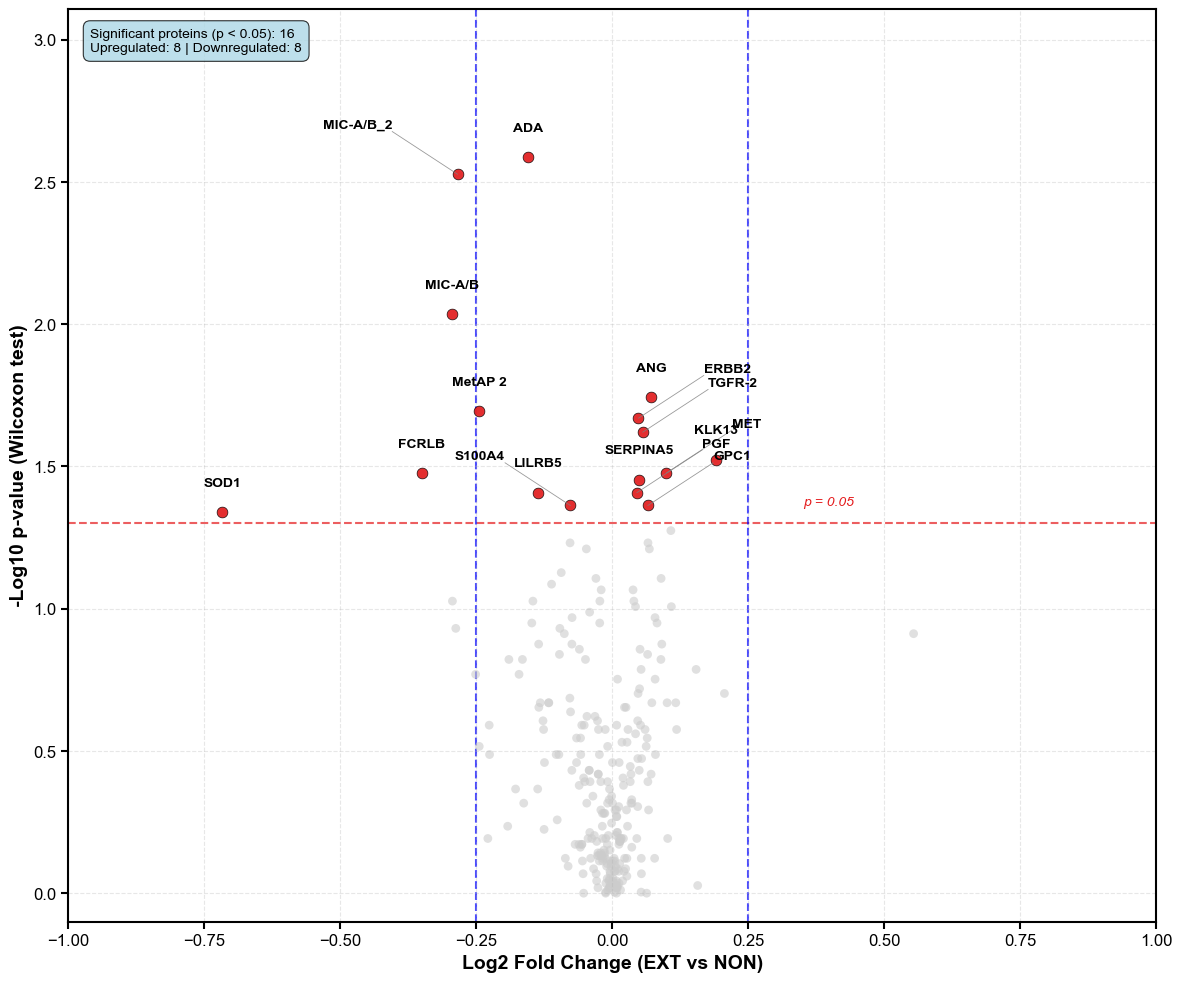

Volcano plot created with 16 significant proteins labeled
Creating Olink heatmap for significant proteins...


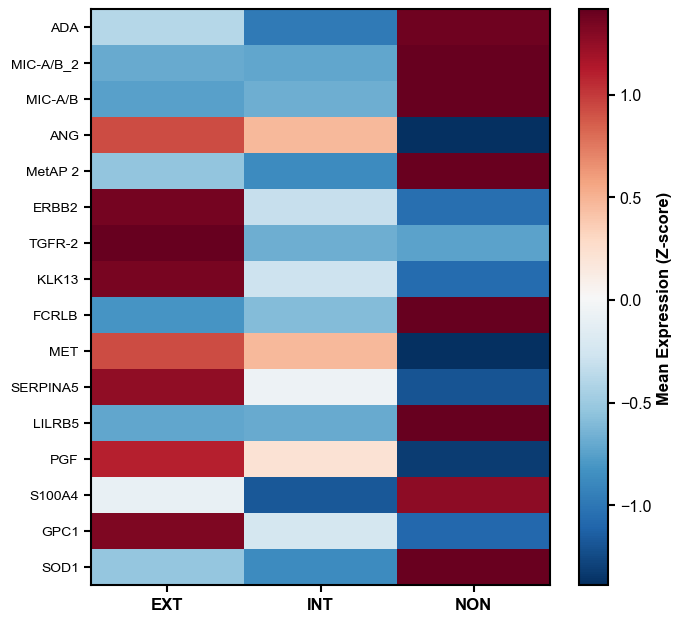

Heatmap created with 16 significant proteins
Creating box plots for top significant proteins...
Selected top 6 proteins for box plots: ADA, MIC-A/B_2, MIC-A/B, ANG, MetAP 2, ERBB2


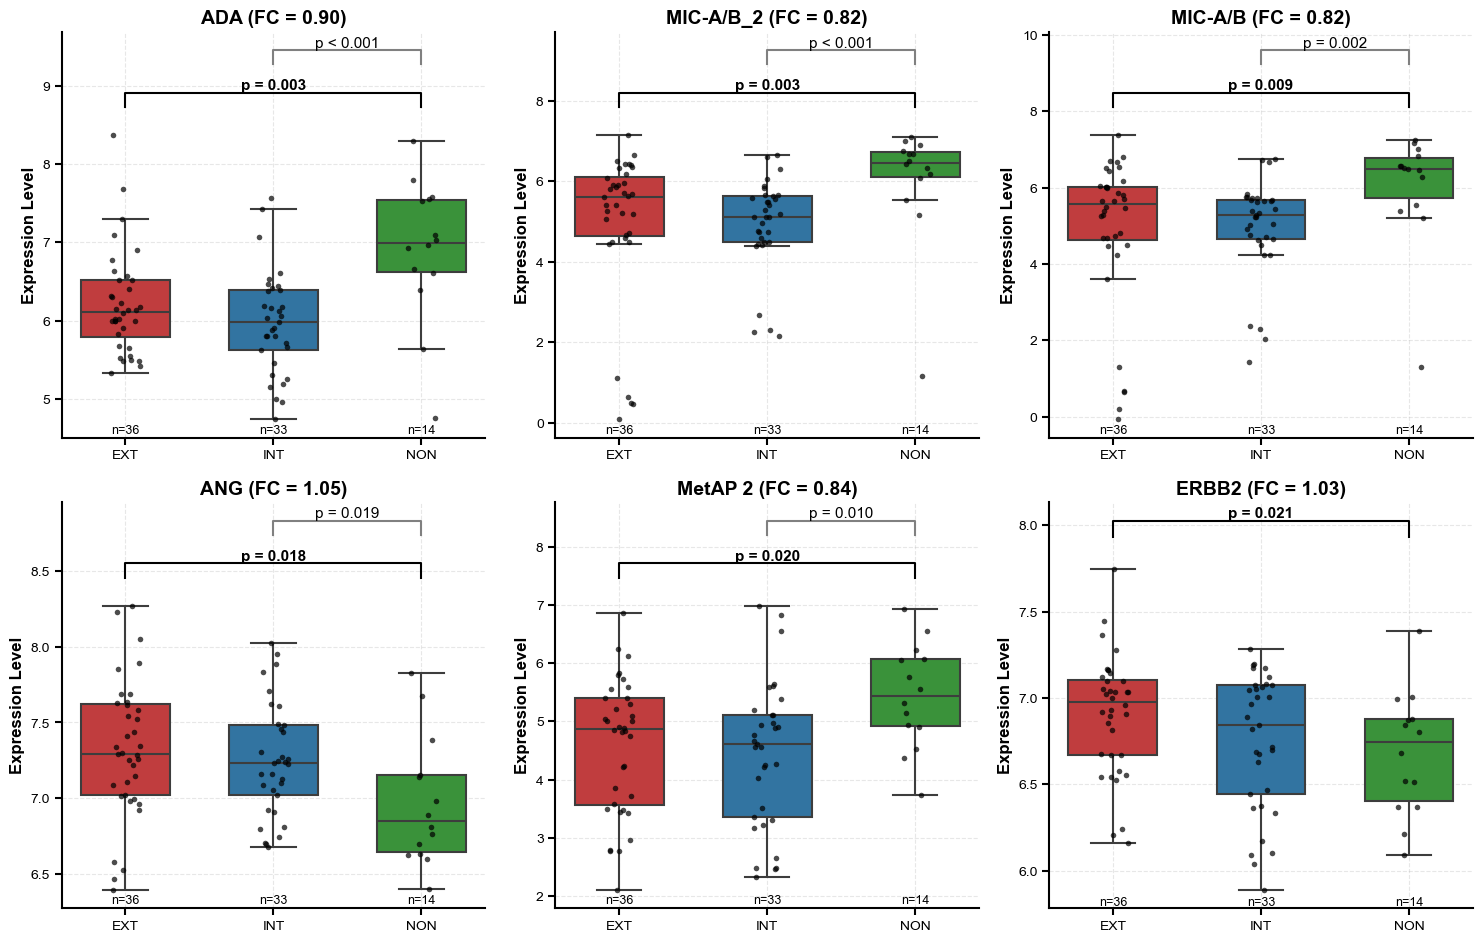

Saved Olink box plots

OLINK VISUALIZATION SUMMARY
Files created:
  - olink_volcano_plot_nature.png/.pdf
  - olink_heatmap_nature.png/.pdf
  - olink_top_proteins_boxplots_wilcoxon.png/.pdf

Statistics:
  Total proteins analyzed: 268
  Significant proteins (p < 0.05): 16
  FDR-significant proteins: 0
  Upregulated in EXT: 8
  Downregulated in EXT: 8

Top significant proteins:
  1. ADA ↓ (p = 0.0026)
  2. MIC-A/B_2 ↓ (p = 0.0030)
  3. MIC-A/B ↓ (p = 0.0092)
  4. ANG ↑ (p = 0.0180)
  5. MetAP 2 ↓ (p = 0.0202)

Visualization style: Matched to Nanostring plots for consistency
Statistical method: Wilcoxon rank-sum test with FDR correction

Note: Ensure the Olink analysis script has been run first to generate required data structures.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plot styles (matching Nanostring)
plt.style.use('default')
sns.set_context("paper", font_scale=1.3)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5

# Load the Olink results
print("Loading Olink analysis results...")
try:
    results_df = pd.read_csv('olink_comprehensive_analysis_nature.csv')
    print(f"Loaded {len(results_df)} proteins from analysis")
except FileNotFoundError:
    print("Error: olink_comprehensive_analysis_nature.csv not found. Please run the Olink analysis first.")
    exit()

# Prepare data for volcano plot
volcano_data = results_df[['Protein', 'EXT_vs_NON_p_value', 'EXT_vs_NON_log2_fold_change', 
                          'EXT_vs_NON_significant_raw', 'EXT_vs_NON_significant_FDR']].copy()
volcano_data = volcano_data.dropna()

print(f"Volcano plot data: {len(volcano_data)} proteins")

#################################################################
# 1. OLINK VOLCANO PLOT
#################################################################
print("Creating Olink volcano plot...")

plt.figure(figsize=(12, 10))

# Create custom color scheme for the plot (matching Nanostring)
base_color = '#cccccc'  # Light gray for non-significant points
sig_color = '#e41a1c'   # Red for significant points

# Create the main scatter plot with all points initially gray
plt.scatter(
    volcano_data['EXT_vs_NON_log2_fold_change'],
    -np.log10(volcano_data['EXT_vs_NON_p_value']),
    alpha=0.6,
    s=40,
    color=base_color,
    edgecolor='none',
    zorder=1
)

# Overlay significant markers
sig_data = volcano_data[volcano_data['EXT_vs_NON_significant_raw']]
if len(sig_data) > 0:
    scatter = plt.scatter(
        sig_data['EXT_vs_NON_log2_fold_change'],
        -np.log10(sig_data['EXT_vs_NON_p_value']),
        alpha=0.9,
        s=60,
        color=sig_color,
        edgecolor='black',
        linewidth=0.5,
        zorder=2
    )

# Highlight FDR-significant markers if any
sig_fdr = volcano_data[volcano_data['EXT_vs_NON_significant_FDR']]
if len(sig_fdr) > 0:
    plt.scatter(
        sig_fdr['EXT_vs_NON_log2_fold_change'],
        -np.log10(sig_fdr['EXT_vs_NON_p_value']),
        alpha=0.9,
        s=70,
        color='darkred',
        edgecolor='black',
        linewidth=0.8,
        zorder=3
    )

# Add horizontal line for p-value threshold
plt.axhline(y=-np.log10(0.05), color='#e41a1c', linestyle='--', alpha=0.7, linewidth=1.5, zorder=0)
plt.text(
    0.35, 
    -np.log10(0.05) + 0.05, 
    'p = 0.05', 
    color='#e41a1c',
    fontsize=10,
    fontstyle='italic',
    verticalalignment='bottom'
)

# Add vertical lines for log2 fold change thresholds
fc_threshold = 0.25
plt.axvline(x=fc_threshold, color='blue', linestyle='--', alpha=0.7, linewidth=1.5, zorder=0)
plt.axvline(x=-fc_threshold, color='blue', linestyle='--', alpha=0.7, linewidth=1.5, zorder=0)

# Position the fold change label better
y_max = max(-np.log10(volcano_data['EXT_vs_NON_p_value']))

# Professional labeling with minimal lines for ALL significant proteins
if len(sig_data) > 0:
    # Use ALL significant proteins, sorted by significance
    sig_data_sorted = sig_data.sort_values('EXT_vs_NON_p_value')
    
    label_positions = []  # Track label positions to detect overlaps
    
    for _, row in sig_data_sorted.iterrows():
        protein = row['Protein']
        x = row['EXT_vs_NON_log2_fold_change']
        y = -np.log10(row['EXT_vs_NON_p_value'])
        
        # Try to place label close to point first
        label_x = x
        label_y = y + 0.08  # Small offset above point
        ha = 'center'
        va = 'bottom'
        needs_line = False
        
        # Check for overlaps with existing labels
        min_distance = 0.15
        for existing_x, existing_y in label_positions:
            distance = ((label_x - existing_x)**2 + (label_y - existing_y)**2)**0.5
            if distance < min_distance:
                needs_line = True
                # Move label further away
                if x < 0:  # Left side
                    label_x = x - 0.12
                    ha = 'right'
                    label_y = y + 0.15
                else:  # Right side
                    label_x = x + 0.12
                    ha = 'left'
                    label_y = y + 0.15
                break
        
        # Draw connecting line only if label was moved far from point
        if needs_line:
            plt.plot([x, label_x], [y, label_y], 
                     color='gray', linewidth=0.6, alpha=0.8, zorder=3)
        
        # Place the label
        plt.text(label_x, label_y, protein,
                fontsize=10,
                fontweight='bold',
                ha=ha,
                va=va,
                zorder=4,
                color='black')
        
        # Record this label position
        label_positions.append((label_x, label_y))
    
    print(f"Labeled all {len(sig_data_sorted)} significant proteins")

plt.xlabel('Log2 Fold Change (EXT vs NON)', fontsize=14, fontweight='bold')
plt.ylabel('-Log10 p-value (Wilcoxon test)', fontsize=14, fontweight='bold')

# Improve axis appearance
plt.grid(alpha=0.3, linestyle='--', zorder=0)

# Set fixed axis limits for better visualization (FIXED SECTION)
plt.xlim(-1.0, 1.0)  # Fixed x-axis limits for better spacing
plt.ylim(-0.1, y_max * 1.2)

# Enhance tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add summary statistics
n_sig_up = sum((sig_data['EXT_vs_NON_log2_fold_change'] > 0)) if len(sig_data) > 0 else 0
n_sig_down = sum((sig_data['EXT_vs_NON_log2_fold_change'] < 0)) if len(sig_data) > 0 else 0
n_total_sig = len(sig_data)

# Create summary box
summary_text = f"Significant proteins (p < 0.05): {n_total_sig}\nUpregulated: {n_sig_up} | Downregulated: {n_sig_down}"
if len(sig_fdr) > 0:
    summary_text += f"\nFDR < 0.05: {len(sig_fdr)}"

plt.annotate(summary_text, 
             xy=(0.02, 0.98), xycoords='axes fraction', 
             fontsize=10, ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.8))

plt.tight_layout()

# Save the volcano plot
plt.savefig('olink_volcano_plot_nature.png', dpi=300, bbox_inches='tight')
plt.savefig('olink_volcano_plot_nature.pdf', bbox_inches='tight')
plt.show()

print(f"Volcano plot created with {n_total_sig} significant proteins labeled")

#################################################################
# 2. OLINK HEATMAP FOR SIGNIFICANT PROTEINS
#################################################################

if n_total_sig > 0:
    print("Creating Olink heatmap for significant proteins...")
    
    # Get significant proteins
    sig_proteins = sig_data['Protein'].tolist()
    
    # Calculate mean expression for each group (using same methodology as Nanostring)
    expression_matrix = []
    protein_names = []
    
    for protein in sig_proteins:
        protein_row = results_df[results_df['Protein'] == protein].iloc[0]
        
        # Get mean values for each group in order: EXT, INT, NON
        means = []
        for response in ['EXT', 'INT', 'NON']:
            mean_col = f'Mean_{response}'
            if mean_col in results_df.columns:
                mean_val = protein_row[mean_col]
                if pd.notna(mean_val):
                    means.append(mean_val)
                else:
                    means.append(np.nan)
            else:
                means.append(np.nan)
        
        # Only include if we have valid data (at least EXT and NON)
        if not pd.isna(means[0]) and not pd.isna(means[2]):  # EXT and NON must be valid
            expression_matrix.append(means)
            protein_names.append(protein)
    
    if expression_matrix:
        expression_matrix = np.array(expression_matrix)
        
        # Z-score normalize each row (matching Nanostring methodology)
        expression_matrix_z = np.zeros_like(expression_matrix)
        for i in range(len(protein_names)):
            row = expression_matrix[i, :]
            valid_values = row[~np.isnan(row)]
            if len(valid_values) > 1 and np.std(valid_values) > 0:
                row_mean = np.mean(valid_values)
                row_std = np.std(valid_values)
                expression_matrix_z[i, :] = (row - row_mean) / row_std
            else:
                expression_matrix_z[i, :] = row - np.mean(valid_values) if len(valid_values) > 0 else row
        
        # Create heatmap with original styling (matching Nanostring)
        plt.figure(figsize=(7, max(6, len(protein_names) * 0.4)))
        im = plt.imshow(expression_matrix_z, aspect='auto', cmap='RdBu_r', interpolation='none')
        
        # Add colorbar
        cbar = plt.colorbar(im)
        cbar.set_label('Mean Expression (Z-score)', fontsize=12, fontweight='bold')
        
        # Add axis labels
        plt.yticks(np.arange(len(protein_names)), protein_names, fontsize=10)
        
        # Determine which groups we actually have data for
        group_labels = []
        group_indices = []
        for i, response in enumerate(['EXT', 'INT', 'NON']):
            if not all(np.isnan(expression_matrix[:, i])):
                group_labels.append(response)
                group_indices.append(i)
        
        plt.xticks(np.arange(len(group_labels)), group_labels, fontsize=12, fontweight='bold')
        
        # Save the heatmap
        plt.tight_layout()
        plt.savefig('olink_heatmap_nature.png', dpi=300, bbox_inches='tight')
        plt.savefig('olink_heatmap_nature.pdf', bbox_inches='tight')
        plt.show()
        
        print(f"Heatmap created with {len(protein_names)} significant proteins")
    else:
        print("No valid expression data found for heatmap")

else:
    print("No significant proteins found - skipping heatmap creation")

#################################################################
# 3. BOX PLOTS FOR TOP SIGNIFICANT PROTEINS
#################################################################

if n_total_sig > 0:
    print("Creating box plots for top significant proteins...")
    
    # Select top proteins based on statistical significance
    top_proteins = sig_data.nsmallest(6, 'EXT_vs_NON_p_value')['Protein'].tolist()
    print(f"Selected top {len(top_proteins)} proteins for box plots: {', '.join(top_proteins)}")
    
    # Create a figure with subplots for each protein
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Sample metadata with expression values for plotting
    plot_data = []
    for protein in top_proteins:
        if protein in filtered_data.index:
            for sample in valid_samples:
                if sample in filtered_data.columns:
                    expression = filtered_data.loc[protein, sample]
                    response = sample_to_response.get(sample)
                    patient = sample_to_patientid.get(sample)
                    if not pd.isna(expression) and response in valid_responses:
                        plot_data.append({
                            'Protein': protein,
                            'Expression': expression,
                            'Response': response,
                            'Patient': patient
                        })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Define the order of response groups for consistent visualization
    response_order = ['EXT', 'INT', 'NON']
    
    # Create box plots for each protein with enhanced styling
    for i, protein in enumerate(top_proteins):
        protein_data = plot_df[plot_df['Protein'] == protein]
        
        # Create the box plot with custom styling
        sns.boxplot(
            x='Response',
            y='Expression',
            data=protein_data,
            palette=response_colors,
            order=response_order,
            ax=axes[i],
            width=0.6,
            linewidth=1.5,
            fliersize=0
        )
        
        # Add individual data points as swarmplot
        sns.stripplot(
            x='Response', 
            y='Expression', 
            data=protein_data,
            order=response_order,
            color='black',
            size=4,
            alpha=0.7,
            ax=axes[i],
            jitter=True
        )
        
        # Get the main comparison result (EXT vs NON)
        ext_non_result = ext_vs_non_results.get(protein)
        ext_int_result = ext_vs_int_results.get(protein)
        int_non_result = int_vs_non_results.get(protein)
        
        # Calculate positions for annotations
        y_max = protein_data['Expression'].max()
        y_min = protein_data['Expression'].min()
        y_range = y_max - y_min
        
        # Add EXT vs NON comparison (main comparison)
        if ext_non_result:
            x1, x2 = 0, 2  # positions for EXT and NON
            y_pos = y_max + y_range * 0.1
            h = y_range * 0.05
            axes[i].plot([x1, x1, x2, x2], [y_pos, y_pos+h, y_pos+h, y_pos], lw=1.5, c='black')
            p_text = f"p = {ext_non_result['p_value']:.3f}" if ext_non_result['p_value'] >= 0.001 else "p < 0.001"
            axes[i].text((x1+x2)*.5, y_pos+h, p_text, ha='center', va='bottom', 
                        color='black', fontsize=11, fontweight='bold')
        
        # Add EXT vs INT comparison if significant
        if ext_int_result and ext_int_result['p_value'] < 0.05:
            x1, x2 = 0, 1  # positions for EXT and INT
            y_pos2 = y_max + y_range * 0.25
            h2 = y_range * 0.05
            axes[i].plot([x1, x1, x2, x2], [y_pos2, y_pos2+h2, y_pos2+h2, y_pos2], lw=1.5, c='gray')
            p_text = f"p = {ext_int_result['p_value']:.3f}" if ext_int_result['p_value'] >= 0.001 else "p < 0.001"
            axes[i].text((x1+x2)*.5, y_pos2+h2, p_text, ha='center', va='bottom', 
                        color='black', fontsize=11)
        
        # Add INT vs NON comparison if significant
        if int_non_result and int_non_result['p_value'] < 0.05:
            x1, x2 = 1, 2  # positions for INT and NON
            y_pos3 = y_max + y_range * 0.4 if (ext_int_result and ext_int_result['p_value'] < 0.05) else y_max + y_range * 0.25
            h3 = y_range * 0.05
            axes[i].plot([x1, x1, x2, x2], [y_pos3, y_pos3+h3, y_pos3+h3, y_pos3], lw=1.5, c='gray')
            p_text = f"p = {int_non_result['p_value']:.3f}" if int_non_result['p_value'] >= 0.001 else "p < 0.001"
            axes[i].text((x1+x2)*.5, y_pos3+h3, p_text, ha='center', va='bottom', 
                        color='black', fontsize=11)
        
        # Set title and labels with enhanced styling
        if ext_non_result:
            fc_text = f" (FC = {ext_non_result['true_fold_change']:.2f})"
        else:
            fc_text = ""
        axes[i].set_title(f'{protein}{fc_text}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Expression Level', fontsize=12, fontweight='bold')
        
        # Improve appearance
        axes[i].grid(alpha=0.3, linestyle='--')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        
        # Enhance tick labels
        axes[i].tick_params(axis='both', which='major', labelsize=10)
        
        # Add sample count per group
        for j, resp in enumerate(response_order):
            n = len(protein_data[protein_data['Response'] == resp])
            axes[i].annotate(f"n={n}", xy=(j, y_min - y_range * 0.05), ha='center', fontsize=9)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save the figure in high resolution
    plt.savefig('olink_top_proteins_boxplots_wilcoxon.png', dpi=600, bbox_inches='tight')
    plt.savefig('olink_top_proteins_boxplots_wilcoxon.pdf', bbox_inches='tight')
    plt.show()
    print("Saved Olink box plots")

else:
    print("No significant proteins found - skipping box plot creation")

# Print summary
print("\n" + "="*60)
print("OLINK VISUALIZATION SUMMARY")
print("="*60)
print("Files created:")
print("  - olink_volcano_plot_nature.png/.pdf")
if n_total_sig > 0:
    print("  - olink_heatmap_nature.png/.pdf")
    print("  - olink_top_proteins_boxplots_wilcoxon.png/.pdf")

print(f"\nStatistics:")
print(f"  Total proteins analyzed: {len(volcano_data)}")
print(f"  Significant proteins (p < 0.05): {n_total_sig}")
print(f"  FDR-significant proteins: {len(sig_fdr)}")

if n_total_sig > 0:
    print(f"  Upregulated in EXT: {n_sig_up}")
    print(f"  Downregulated in EXT: {n_sig_down}")
    
    print(f"\nTop significant proteins:")
    for i, (_, row) in enumerate(sig_data.head(5).iterrows(), 1):
        direction = "↑" if row['EXT_vs_NON_log2_fold_change'] > 0 else "↓"
        print(f"  {i}. {row['Protein']} {direction} (p = {row['EXT_vs_NON_p_value']:.4f})")

print(f"\nVisualization style: Matched to Nanostring plots for consistency")
print(f"Statistical method: Wilcoxon rank-sum test with FDR correction")

# Note: This script requires the following variables from the Olink analysis:
# - filtered_data (protein expression matrix)
# - valid_samples (list of valid sample IDs)
# - sample_to_response (sample to response group mapping)
# - sample_to_patientid (sample to patient ID mapping)
# - response_colors (color scheme for response groups)
# - valid_responses (list of valid response categories)
print(f"\nNote: Ensure the Olink analysis script has been run first to generate required data structures.")

COMPREHENSIVE TIME-DEPENDENT OLINK ANALYSIS
Loading Olink protein data...
Processed protein matrix shape: (276, 89)
Loading sample information...
Mapping samples to patient and temporal information...
Successfully mapped 83 samples
Samples with valid temporal information: 83
Dataset: 276 proteins across 83 samples
OLINK PEMBROLIZUMAB + IL-2 STUDY TEMPORAL STRUCTURE
Treatment Phase Distribution:
  Pembrolizumab_IL2: 43 samples (EXT: 18, INT: 17, NON: 8)
  Pembrolizumab_Mono_1: 24 samples (EXT: 9, INT: 10, NON: 5)
  Pembrolizumab_Mono_2: 16 samples (EXT: 9, INT: 6, NON: 1)

Treatment Block Distribution:
  Block 1: 24 samples (EXT: 9, INT: 10, NON: 5)
  Block 2: 43 samples (EXT: 18, INT: 17, NON: 8)
  Block 4: 16 samples (EXT: 9, INT: 6, NON: 1)

Detailed Timepoint Distribution (Block-Week):
  B1W1: 24 samples (EXT: 9, INT: 10, NON: 5)
  B2W2: 22 samples (EXT: 9, INT: 9, NON: 4)
  B2W4: 21 samples (EXT: 9, INT: 8, NON: 4)
  B4W1: 16 samples (EXT: 9, INT: 6, NON: 1)

Longitudinal Structure

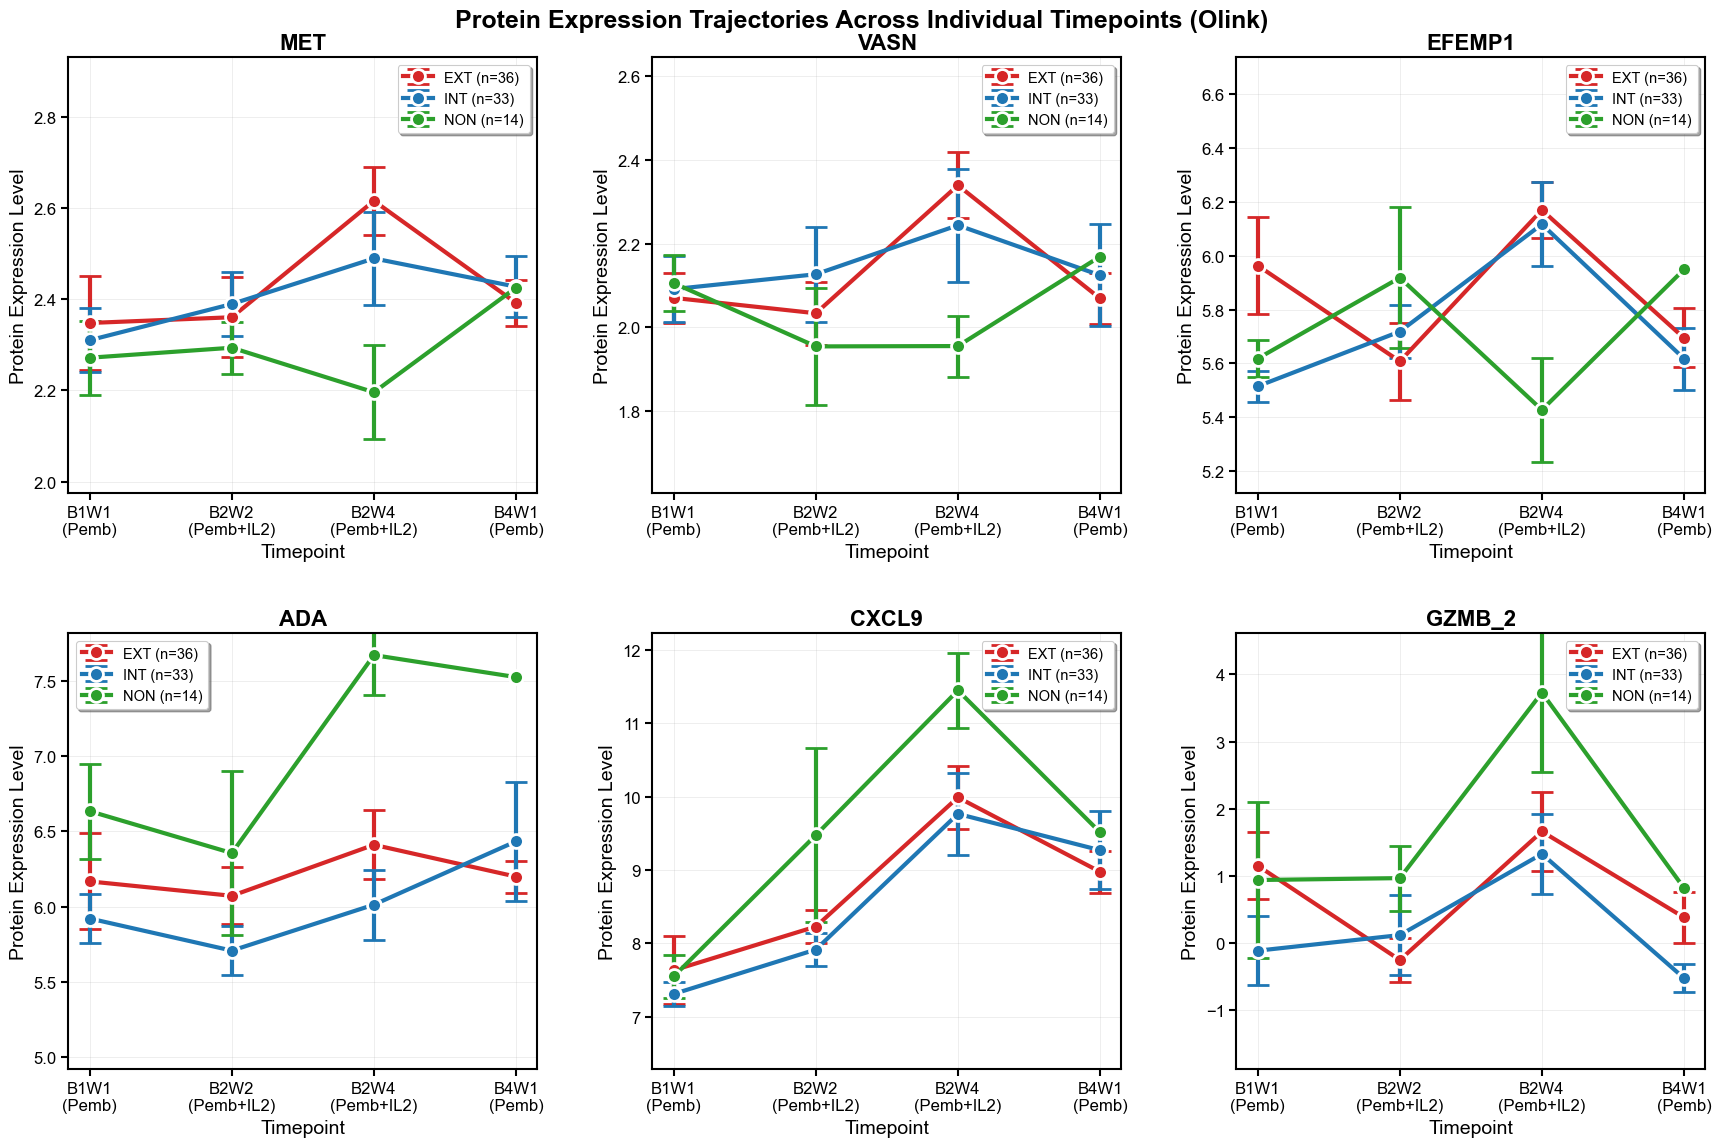

Creating temporal heatmap for Olink...
Olink temporal heatmap saved as PNG and PDF


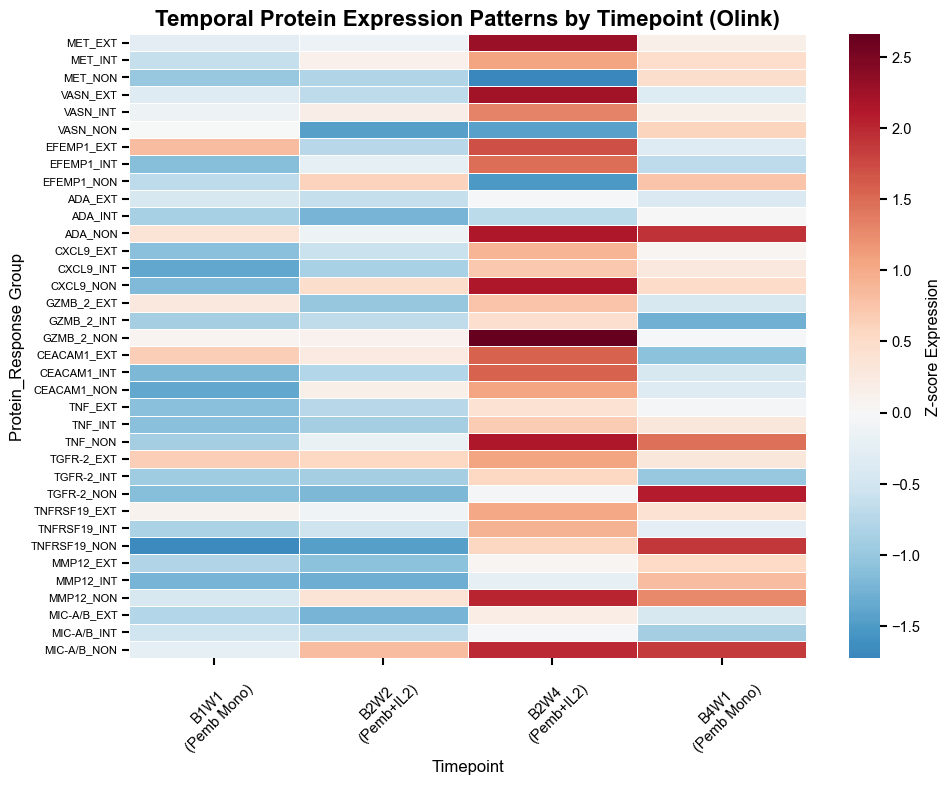


OLINK PEMBROLIZUMAB + IL-2 TEMPORAL ANALYSIS SUMMARY

Timepoint Analysis:
  Total protein comparisons: 828
  Significant (p < 0.05): 45
  Significant (FDR < 0.05): 0
    B1W1: 9/276 significant
    B2W2: 3/276 significant
    B2W4: 33/276 significant

Phase Analysis:
  Total protein comparisons: 552
  Significant (p < 0.05): 25
  Significant (FDR < 0.05): 0
    Pembrolizumab_IL2: 16/276 significant
    Pembrolizumab_Mono_1: 9/276 significant

Block Analysis:
  Total protein comparisons: 552
  Significant (p < 0.05): 25
  Significant (FDR < 0.05): 0
    Block_1: 9/276 significant
    Block_2: 16/276 significant

Longitudinal Mixed Effects Analysis (276 proteins):
  Model 1 (Study Week Effects):
    Response effects: 0
    Time effects: 45
    Response×Time interactions (EXT): 0
  Model 2 (Treatment Phase Effects):
    IL-2 phase vs Mono phase 1: 0
    Mono phase 2 vs Mono phase 1: 50
  Model 3 (Treatment Block Effects):
    Block effects: 46

Treatment Design Summary:
  Block 1: Pembro

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import mixedlm
import warnings
import re
warnings.filterwarnings('ignore')

# Set publication-quality plot styles
plt.style.use('default')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5

# Custom color palette (Nature-style, colorblind-friendly)
response_colors = {'EXT': '#d62728', 'INT': '#1f77b4', 'NON': '#2ca02c'}
timepoint_colors = {'BL': '#8c564b', 'V3': '#e377c2', 'V5': '#7f7f7f', 'EOT': '#bcbd22'}

def extract_timepoint_and_week_olink(sample_id):
    """
    Extract timepoint for pembrolizumab + IL-2 study using blocks and weeks for Olink data
    Example: 01-027B2W2 = Subject 027, Block 2 Week 2
    """
    # Parse the sample ID components - focus on subject, block and week
    # Pattern: {prefix}-{subject}B{block}W{week}
    match = re.match(r'(\d+)-(\d+)B(\d+)W(\d+)', sample_id)
    
    if match:
        prefix = match.group(1)
        subject = match.group(2)
        block = int(match.group(3))
        week = int(match.group(4))
        
        # Create timepoint identifier using block and week
        timepoint = f"B{block}W{week}"
        
        # Calculate study week based on block and week
        # Block 1: Weeks 1-9 (pembrolizumab monotherapy)
        # Block 2: Weeks 10-18 (pembrolizumab + IL-2)
        # Block 3: Weeks 19-27 (pembrolizumab + IL-2) 
        # Block 4: Weeks 28-36 (pembrolizumab monotherapy)
        
        if block == 1:
            study_week = week
        elif block == 2:
            study_week = 9 + week
        elif block == 3:
            study_week = 18 + week
        elif block == 4:
            study_week = 27 + week
        else:
            study_week = None
        
        # Determine treatment phase
        if block == 1:
            phase = "Pembrolizumab_Mono_1"
        elif block in [2, 3]:
            phase = "Pembrolizumab_IL2"
        elif block == 4:
            phase = "Pembrolizumab_Mono_2"
        else:
            phase = "Unknown"
        
        return {
            'timepoint': timepoint,
            'study_week': study_week,
            'block': block,
            'week_in_block': week,
            'phase': phase,
            'subject': subject
        }
    
    return None

def assess_temporal_structure_olink(sample_temporal_info, sample_to_response):
    """Assess the temporal data structure for pembrolizumab + IL-2 study (Olink)"""
    
    # Organize by different temporal dimensions
    timepoint_summary = {}  # By block-week
    phase_summary = {}      # By treatment phase
    block_summary = {}      # By treatment block
    patient_timepoint_counts = {}
    
    for sample, temporal_info in sample_temporal_info.items():
        if temporal_info and sample in sample_to_response:
            response = sample_to_response[sample]
            timepoint = temporal_info['timepoint']
            phase = temporal_info['phase']
            block = temporal_info['block']
            subject = temporal_info['subject']
            
            # Track timepoint distribution (Block-Week)
            if timepoint not in timepoint_summary:
                timepoint_summary[timepoint] = {'EXT': 0, 'INT': 0, 'NON': 0}
            timepoint_summary[timepoint][response] += 1
            
            # Track phase distribution
            if phase not in phase_summary:
                phase_summary[phase] = {'EXT': 0, 'INT': 0, 'NON': 0}
            phase_summary[phase][response] += 1
            
            # Track block distribution
            if block not in block_summary:
                block_summary[block] = {'EXT': 0, 'INT': 0, 'NON': 0}
            block_summary[block][response] += 1
            
            # Track patient longitudinal data
            if subject not in patient_timepoint_counts:
                patient_timepoint_counts[subject] = {
                    'timepoints': set(),
                    'blocks': set(),
                    'phases': set(),
                    'study_weeks': set()
                }
            patient_timepoint_counts[subject]['timepoints'].add(timepoint)
            patient_timepoint_counts[subject]['blocks'].add(block)
            patient_timepoint_counts[subject]['phases'].add(phase)
            if temporal_info['study_week']:
                patient_timepoint_counts[subject]['study_weeks'].add(temporal_info['study_week'])
    
    # Assess longitudinal vs cross-sectional structure
    longitudinal_patients = {
        p: len(data['timepoints']) 
        for p, data in patient_timepoint_counts.items() 
        if len(data['timepoints']) > 1
    }
    
    print("OLINK PEMBROLIZUMAB + IL-2 STUDY TEMPORAL STRUCTURE")
    print("="*60)
    
    print("Treatment Phase Distribution:")
    for phase, counts in sorted(phase_summary.items()):
        total = sum(counts.values())
        print(f"  {phase}: {total} samples (EXT: {counts['EXT']}, INT: {counts['INT']}, NON: {counts['NON']})")
    
    print("\nTreatment Block Distribution:")
    for block, counts in sorted(block_summary.items()):
        total = sum(counts.values())
        print(f"  Block {block}: {total} samples (EXT: {counts['EXT']}, INT: {counts['INT']}, NON: {counts['NON']})")
    
    print("\nDetailed Timepoint Distribution (Block-Week):")
    for tp in sorted(timepoint_summary.keys()):
        counts = timepoint_summary[tp]
        total = sum(counts.values())
        print(f"  {tp}: {total} samples (EXT: {counts['EXT']}, INT: {counts['INT']}, NON: {counts['NON']})")
    
    print(f"\nLongitudinal Structure:")
    print(f"  Total patients: {len(patient_timepoint_counts)}")
    print(f"  Patients with multiple timepoints: {len(longitudinal_patients)}")
    print(f"  Patients with single timepoint: {len(patient_timepoint_counts) - len(longitudinal_patients)}")
    
    if len(longitudinal_patients) > 0:
        timepoint_dist = list(longitudinal_patients.values())
        print(f"  Average timepoints per longitudinal patient: {np.mean(timepoint_dist):.1f}")
        print(f"  Max timepoints per patient: {max(timepoint_dist)}")
        
        # Analyze treatment progression
        multi_block_patients = sum(1 for data in patient_timepoint_counts.values() if len(data['blocks']) > 1)
        multi_phase_patients = sum(1 for data in patient_timepoint_counts.values() if len(data['phases']) > 1)
        
        print(f"  Patients with multiple treatment blocks: {multi_block_patients}")
        print(f"  Patients with multiple treatment phases: {multi_phase_patients}")
    
    return {
        'timepoint_summary': timepoint_summary,
        'phase_summary': phase_summary, 
        'block_summary': block_summary,
        'patient_timepoint_counts': patient_timepoint_counts,
        'longitudinal_patients': longitudinal_patients
    }

def robust_differential_analysis_temporal_olink(data, protein, group1, group2, sample_groups, 
                                        sample_temporal_info, timepoint=None, phase=None, 
                                        block=None, min_samples=3):
    """
    Enhanced differential analysis with flexible temporal filtering using Wilcoxon rank-sum test for Olink
    """
    # Get samples for each group with temporal filtering
    def passes_temporal_filter(sample):
        if sample not in sample_temporal_info:
            return False
        
        temporal_info = sample_temporal_info[sample]
        if temporal_info is None:
            return False
        if timepoint and temporal_info['timepoint'] != timepoint:
            return False
        if phase and temporal_info['phase'] != phase:
            return False
        if block and temporal_info['block'] != block:
            return False
        
        return True
    
    group1_cols = [col for col in data.columns 
                   if sample_groups.get(col) == group1 and passes_temporal_filter(col)]
    group2_cols = [col for col in data.columns 
                   if sample_groups.get(col) == group2 and passes_temporal_filter(col)]
    
    # Require minimum sample size
    if len(group1_cols) < min_samples or len(group2_cols) < min_samples:
        return None
    
    # Get expression values
    group1_vals = data.loc[protein, group1_cols].values.astype(float)
    group2_vals = data.loc[protein, group2_cols].values.astype(float)
    
    # Remove NaN values
    group1_vals = group1_vals[~np.isnan(group1_vals)]
    group2_vals = group2_vals[~np.isnan(group2_vals)]
    
    if len(group1_vals) < min_samples or len(group2_vals) < min_samples:
        return None
    
    # Calculate statistics
    mean_group1 = np.mean(group1_vals)
    mean_group2 = np.mean(group2_vals)
    mean_difference = mean_group1 - mean_group2
    true_fold_change = mean_group1 / mean_group2 if mean_group2 > 0 else np.nan
    log2_fold_change = np.log2(true_fold_change) if true_fold_change > 0 else np.nan
    
    # Cohen's d
    pooled_std = np.sqrt(((len(group1_vals) - 1) * np.var(group1_vals, ddof=1) + 
                         (len(group2_vals) - 1) * np.var(group2_vals, ddof=1)) / 
                        (len(group1_vals) + len(group2_vals) - 2))
    cohens_d = mean_difference / pooled_std if pooled_std > 0 else np.nan
    
    # Wilcoxon rank-sum test (Mann-Whitney U)
    try:
        statistic, p_val = mannwhitneyu(group1_vals, group2_vals, alternative='two-sided')
        n1, n2 = len(group1_vals), len(group2_vals)
        rank_biserial_r = 1 - (2 * statistic) / (n1 * n2)
    except ValueError:
        p_val = 1.0
        statistic = np.nan
        rank_biserial_r = 0.0
    
    return {
        'p_value': p_val,
        'statistic': statistic,
        'mean_difference': mean_difference,
        'true_fold_change': true_fold_change,
        'log2_fold_change': log2_fold_change,
        'cohens_d': cohens_d,
        'rank_biserial_r': rank_biserial_r,
        'mean_group1': mean_group1,
        'mean_group2': mean_group2,
        'std_group1': np.std(group1_vals, ddof=1),
        'std_group2': np.std(group2_vals, ddof=1),
        'sem_group1': stats.sem(group1_vals),
        'sem_group2': stats.sem(group2_vals),
        'n_group1': len(group1_vals),
        'n_group2': len(group2_vals)
    }

def perform_longitudinal_analysis_olink(protein_data, sample_temporal_info, sample_to_response):
    """
    Perform mixed effects analysis for pembrolizumab + IL-2 longitudinal data (Olink)
    """
    print("Performing mixed effects analysis for Olink pembrolizumab + IL-2 study...")
    
    longitudinal_results = []
    
    for protein in protein_data.index:
        # Prepare data for this protein
        protein_data_rows = []
        for sample in protein_data.columns:
            if (sample in sample_to_response and 
                sample in sample_temporal_info and
                sample_temporal_info[sample] is not None):
                
                temporal_info = sample_temporal_info[sample]
                
                protein_data_rows.append({
                    'expression': protein_data.loc[protein, sample],
                    'patient_id': temporal_info['subject'],
                    'response': sample_to_response[sample],
                    'timepoint': temporal_info['timepoint'],
                    'study_week': temporal_info['study_week'],
                    'block': temporal_info['block'],
                    'phase': temporal_info['phase'],
                    'week_in_block': temporal_info['week_in_block']
                })
        
        df = pd.DataFrame(protein_data_rows).dropna()
        
        # Require minimum sample size and multiple timepoints
        if len(df) > 15 and len(df['study_week'].unique()) > 1:
            try:
                # Model 1: Basic longitudinal model with study week
                model1 = mixedlm("expression ~ C(response) * study_week", 
                               df, groups=df["patient_id"])
                result1 = model1.fit()
                
                # Model 2: Treatment phase model  
                model2 = mixedlm("expression ~ C(response) * C(phase)", 
                               df, groups=df["patient_id"])
                result2 = model2.fit()
                
                # Model 3: Treatment block model
                model3 = mixedlm("expression ~ C(response) * C(block)", 
                               df, groups=df["patient_id"])
                result3 = model3.fit()
                
                # Extract key p-values from each model
                pvals1 = result1.pvalues
                pvals2 = result2.pvalues
                pvals3 = result3.pvalues
                
                longitudinal_results.append({
                    'protein': protein,
                    
                    # Model 1: Study week effects
                    'response_effect_p': pvals1.get('C(response)[T.EXT]', np.nan),
                    'study_week_effect_p': pvals1.get('study_week', np.nan),
                    'interaction_EXT_week_p': pvals1.get('C(response)[T.EXT]:study_week', np.nan),
                    'interaction_INT_week_p': pvals1.get('C(response)[T.INT]:study_week', np.nan),
                    
                    # Model 2: Treatment phase effects
                    'phase_Pemb_IL2_vs_Mono1_p': pvals2.get('C(phase)[T.Pembrolizumab_IL2]', np.nan),
                    'phase_Mono2_vs_Mono1_p': pvals2.get('C(phase)[T.Pembrolizumab_Mono_2]', np.nan),
                    'interaction_EXT_PembIL2_p': pvals2.get('C(response)[T.EXT]:C(phase)[T.Pembrolizumab_IL2]', np.nan),
                    'interaction_EXT_Mono2_p': pvals2.get('C(response)[T.EXT]:C(phase)[T.Pembrolizumab_Mono_2]', np.nan),
                    
                    # Model 3: Treatment block effects
                    'block_effect_p': pvals3.get('C(block)[T.2]', np.nan),  # Block 2 vs Block 1
                    'interaction_EXT_block2_p': pvals3.get('C(response)[T.EXT]:C(block)[T.2]', np.nan),
                    
                    # Model fit statistics
                    'aic_model1': result1.aic,
                    'aic_model2': result2.aic,
                    'aic_model3': result3.aic,
                    'best_model': 1 if result1.aic <= result2.aic and result1.aic <= result3.aic 
                                 else (2 if result2.aic <= result3.aic else 3),
                    
                    # Sample information
                    'n_samples': len(df),
                    'n_patients': len(df['patient_id'].unique()),
                    'n_timepoints': len(df['study_week'].unique()),
                    'n_phases': len(df['phase'].unique()),
                    'n_blocks': len(df['block'].unique()),
                    'converged_all_models': result1.converged and result2.converged and result3.converged
                })
                
            except Exception as e:
                print(f"Error analyzing {protein}: {e}")
                continue
    
    return pd.DataFrame(longitudinal_results)

def time_stratified_analysis_olink(protein_data, sample_to_response, sample_temporal_info, analysis_levels):
    """
    Perform differential protein expression analysis stratified by blocks and phases for Olink
    """
    print("Performing comprehensive time-stratified analysis for Olink...")
    
    results = {
        'by_timepoint': {},
        'by_phase': {},
        'by_block': {}
    }
    
    # Analysis by specific timepoints (B1W1, B2W1, etc.)
    available_timepoints = list(set(info['timepoint'] for info in sample_temporal_info.values() if info))
    print(f"  Analyzing by timepoints: {sorted(available_timepoints)}")
    
    for timepoint in sorted(available_timepoints):
        print(f"    Timepoint: {timepoint}")
        
        # Count samples per group at this timepoint
        group_counts = {}
        for sample, temporal_info in sample_temporal_info.items():
            if temporal_info and temporal_info['timepoint'] == timepoint and sample in sample_to_response:
                response = sample_to_response[sample]
                group_counts[response] = group_counts.get(response, 0) + 1
        
        print(f"      Sample distribution: {group_counts}")
        
        if group_counts.get('EXT', 0) >= 3 and group_counts.get('NON', 0) >= 3:
            timepoint_results = {}
            
            for protein in protein_data.index:
                result = robust_differential_analysis_temporal_olink(
                    protein_data, protein, 'EXT', 'NON', 
                    sample_to_response, sample_temporal_info, timepoint=timepoint
                )
                if result:
                    timepoint_results[protein] = result
            
            results['by_timepoint'][timepoint] = timepoint_results
            print(f"      Analyzed {len(timepoint_results)} proteins")
    
    # Analysis by treatment phase
    available_phases = list(set(info['phase'] for info in sample_temporal_info.values() if info))
    print(f"  Analyzing by treatment phases: {sorted(available_phases)}")
    
    for phase in sorted(available_phases):
        print(f"    Phase: {phase}")
        
        # Count samples per group in this phase
        group_counts = {}
        for sample, temporal_info in sample_temporal_info.items():
            if temporal_info and temporal_info['phase'] == phase and sample in sample_to_response:
                response = sample_to_response[sample]
                group_counts[response] = group_counts.get(response, 0) + 1
        
        print(f"      Sample distribution: {group_counts}")
        
        if group_counts.get('EXT', 0) >= 3 and group_counts.get('NON', 0) >= 3:
            phase_results = {}
            
            for protein in protein_data.index:
                result = robust_differential_analysis_temporal_olink(
                    protein_data, protein, 'EXT', 'NON', 
                    sample_to_response, sample_temporal_info, phase=phase
                )
                if result:
                    phase_results[protein] = result
            
            results['by_phase'][phase] = phase_results
            print(f"      Analyzed {len(phase_results)} proteins")
    
    # Analysis by treatment block
    available_blocks = list(set(info['block'] for info in sample_temporal_info.values() if info))
    print(f"  Analyzing by treatment blocks: {sorted(available_blocks)}")
    
    for block in sorted(available_blocks):
        print(f"    Block: {block}")
        
        # Count samples per group in this block
        group_counts = {}
        for sample, temporal_info in sample_temporal_info.items():
            if temporal_info and temporal_info['block'] == block and sample in sample_to_response:
                response = sample_to_response[sample]
                group_counts[response] = group_counts.get(response, 0) + 1
        
        print(f"      Sample distribution: {group_counts}")
        
        if group_counts.get('EXT', 0) >= 3 and group_counts.get('NON', 0) >= 3:
            block_results = {}
            
            for protein in protein_data.index:
                result = robust_differential_analysis_temporal_olink(
                    protein_data, protein, 'EXT', 'NON', 
                    sample_to_response, sample_temporal_info, block=block
                )
                if result:
                    block_results[protein] = result
            
            results['by_block'][block] = block_results
            print(f"      Analyzed {len(block_results)} proteins")
    
    return results

def create_trajectory_plots_timepoints_olink(protein_data, sample_temporal_info, sample_to_response, top_proteins, save_plots=True):
    """
    Create time-course trajectory plots using individual timepoints on x-axis for Olink
    """
    print("Creating trajectory plots by timepoints for Olink...")
    
    n_proteins = min(len(top_proteins), 6)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Define timepoint order and labels
    timepoint_order = ['B1W1', 'B2W2', 'B2W4', 'B4W1']
    timepoint_labels = {
        'B1W1': 'B1W1\n(Pemb)',
        'B2W2': 'B2W2\n(Pemb+IL2)', 
        'B2W4': 'B2W4\n(Pemb+IL2)',
        'B4W1': 'B4W1\n(Pemb)'
    }
    
    for i, protein in enumerate(top_proteins[:n_proteins]):
        # Prepare data for this protein
        plot_data = []
        for sample in protein_data.columns:
            if (sample in sample_to_response and 
                sample in sample_temporal_info and 
                sample_temporal_info[sample] is not None):
                
                temporal_info = sample_temporal_info[sample]
                
                plot_data.append({
                    'expression': protein_data.loc[protein, sample],
                    'timepoint': temporal_info['timepoint'],
                    'response': sample_to_response[sample],
                    'patient': temporal_info['subject']
                })
        
        df = pd.DataFrame(plot_data).dropna()
        
        if len(df) == 0:
            continue
        
        # Plot trajectories by response group
        for response in ['EXT', 'INT', 'NON']:
            response_data = df[df['response'] == response]
            if len(response_data) == 0:
                continue
            
            # Mean trajectory with error bars by timepoint
            mean_data = []
            for tp_idx, timepoint in enumerate(timepoint_order):
                timepoint_data = response_data[response_data['timepoint'] == timepoint]
                if len(timepoint_data) > 0:
                    mean_expr = timepoint_data['expression'].mean()
                    sem_expr = timepoint_data['expression'].sem()
                    n_samples = len(timepoint_data)
                    mean_data.append({
                        'timepoint_idx': tp_idx,
                        'timepoint': timepoint,
                        'mean': mean_expr,
                        'sem': sem_expr,
                        'n': n_samples
                    })
            
            if len(mean_data) > 0:
                mean_df = pd.DataFrame(mean_data)
                
                # Plot mean trajectory
                axes[i].errorbar(mean_df['timepoint_idx'], mean_df['mean'],
                               yerr=mean_df['sem'],
                               color=response_colors[response], linewidth=3, 
                               label=f'{response} (n={len(response_data)})', 
                               marker='o', markersize=10, capsize=8,
                               markeredgewidth=2, markeredgecolor='white')
        
        # Customize plot
        axes[i].set_title(f'{protein}', fontsize=16, fontweight='bold')
        axes[i].set_xlabel('Timepoint', fontsize=14)
        axes[i].set_ylabel('Protein Expression Level', fontsize=14)
        
        # Set x-axis to show timepoints
        axes[i].set_xticks(range(len(timepoint_order)))
        axes[i].set_xticklabels([timepoint_labels[tp] for tp in timepoint_order])
        
        # Add grid for readability
        axes[i].grid(alpha=0.3, linestyle='-', linewidth=0.5)
        
        # Legend
        axes[i].legend(loc='best', frameon=True, fancybox=True, shadow=True)
        
        # Improve tick formatting
        axes[i].tick_params(labelsize=12)
        
        # Set reasonable y-axis limits
        all_data = df['expression'].values
        y_min, y_max = np.percentile(all_data, [5, 95])
        y_range = y_max - y_min
        axes[i].set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
    
    # Remove empty subplots
    for j in range(n_proteins, len(axes)):
        fig.delaxes(axes[j])
    
    # Improve overall layout
    plt.tight_layout(pad=3.0)
    
    # Add overall title
    fig.suptitle('Protein Expression Trajectories Across Individual Timepoints (Olink)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    if save_plots:
        plt.savefig('olink_trajectory_timepoints.png', dpi=300, bbox_inches='tight')
        plt.savefig('olink_trajectory_timepoints.pdf', bbox_inches='tight')
        print("Olink timepoint trajectory plots saved as PNG and PDF")
    
    plt.show()

def create_temporal_heatmap_olink(protein_data, sample_temporal_info, sample_to_response, significant_proteins, save_plots=True):
    """
    Create heatmap showing protein expression patterns over specific timepoints by response group for Olink
    """
    print("Creating temporal heatmap for Olink...")
    
    # Use specific timepoints instead of blocks
    unique_timepoints = ['B1W1', 'B2W2', 'B2W4', 'B4W1']
    
    # Calculate mean expression by timepoint and response
    heatmap_data = []
    row_labels = []
    
    for protein in significant_proteins[:20]:  # Limit to top 20 for readability
        for response in ['EXT', 'INT', 'NON']:
            row_data = []
            for timepoint in unique_timepoints:
                samples = [s for s in sample_to_response.keys() if 
                          sample_to_response[s] == response and 
                          sample_temporal_info.get(s) and
                          sample_temporal_info[s]['timepoint'] == timepoint]
                
                if samples and len(samples) > 0:
                    mean_expr = protein_data.loc[protein, samples].mean()
                    row_data.append(mean_expr)
                else:
                    row_data.append(np.nan)
            
            heatmap_data.append(row_data)
            row_labels.append(f"{protein}_{response}")
    
    # Create heatmap
    plt.figure(figsize=(10, max(8, len(significant_proteins) * 0.6)))
    
    # Convert to numpy array and handle NaNs
    heatmap_array = np.array(heatmap_data)
    
    # Z-score normalize each protein across timepoints
    protein_normalized_data = []
    for i in range(0, len(heatmap_array), 3):  # Every 3 rows is one protein
        protein_data_vals = heatmap_array[i:i+3]
        # Calculate z-score across all timepoints for this protein
        protein_mean = np.nanmean(protein_data_vals)
        protein_std = np.nanstd(protein_data_vals)
        if protein_std > 0:
            protein_normalized = (protein_data_vals - protein_mean) / protein_std
        else:
            protein_normalized = protein_data_vals - protein_mean
        protein_normalized_data.extend(protein_normalized)
    
    normalized_array = np.array(protein_normalized_data)
    
    # Create timepoint labels with treatment info
    timepoint_labels = []
    for timepoint in unique_timepoints:
        if timepoint == 'B1W1':
            timepoint_labels.append(f"{timepoint}\n(Pemb Mono)")
        elif timepoint in ['B2W2', 'B2W4']:
            timepoint_labels.append(f"{timepoint}\n(Pemb+IL2)")
        elif timepoint == 'B4W1':
            timepoint_labels.append(f"{timepoint}\n(Pemb Mono)")
        else:
            timepoint_labels.append(timepoint)
    
    sns.heatmap(normalized_array, 
                xticklabels=timepoint_labels,
                yticklabels=row_labels,
                cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Z-score Expression'},
                linewidths=0.5)
    
    plt.title('Temporal Protein Expression Patterns by Timepoint (Olink)', fontsize=16, fontweight='bold')
    plt.xlabel('Timepoint', fontsize=12)
    plt.ylabel('Protein_Response Group', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0, fontsize=8)
    
    if save_plots:
        plt.savefig('olink_temporal_heatmap.png', dpi=300, bbox_inches='tight')
        plt.savefig('olink_temporal_heatmap.pdf', bbox_inches='tight')
        print("Olink temporal heatmap saved as PNG and PDF")

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN OLINK LONGITUDINAL ANALYSIS EXECUTION
# =============================================================================

print("COMPREHENSIVE TIME-DEPENDENT OLINK ANALYSIS")
print("=" * 60)

# Load and process Olink data (using your existing code structure)
print("Loading Olink protein data...")
olink_raw = pd.read_csv('olink_data.csv')

# Extract sample IDs (rows 3 onwards, first column)
sample_ids = olink_raw.iloc[3:, 0].tolist()

# Extract the protein columns (excluding QC Warning, Plate ID columns)
panel_row = olink_raw.iloc[0, 1:].tolist()

# Create protein labels by adding indices to handle duplicates
protein_cols = []
protein_counts = {}

for panel in panel_row:
    if pd.isna(panel) or 'Plate ID' in str(panel) or 'QC Warning' in str(panel):
        protein_cols.append(None)  # Skip non-protein columns
    else:
        # Extract protein name from panel
        if isinstance(panel, str):
            parts = panel.split('(')
            if len(parts) > 0:
                protein_name = parts[0].strip()
            else:
                protein_name = panel
        else:
            protein_name = str(panel)
        
        # Handle duplicates by adding a counter
        if protein_name in protein_counts:
            protein_counts[protein_name] += 1
            unique_name = f"{protein_name}_{protein_counts[protein_name]}"
        else:
            protein_counts[protein_name] = 1
            unique_name = protein_name
        
        protein_cols.append(unique_name)

# Create protein matrix
protein_matrix = pd.DataFrame(index=[p for p in protein_cols if p is not None], columns=sample_ids)

# Fill the matrix with expression values
for idx, sample_id in enumerate(sample_ids):
    data_row = olink_raw.iloc[idx + 3, 1:]  # +3 to skip header rows, +1 to skip sample ID column
    
    for val, protein_name in zip(data_row, protein_cols):
        if protein_name is not None:  # Skip non-protein columns
            protein_matrix.loc[protein_name, sample_id] = pd.to_numeric(val, errors='coerce')

print(f"Processed protein matrix shape: {protein_matrix.shape}")

# Load sample information
print("Loading sample information...")
sample_info_df = pd.read_csv('sample_info.csv', quotechar='"')

# Clean up column names and values
sample_info_df.columns = sample_info_df.columns.str.strip('"')
for col in sample_info_df.columns:
    if sample_info_df[col].dtype == 'object':
        sample_info_df[col] = sample_info_df[col].str.strip('"')

# Define valid response categories
valid_responses = ['EXT', 'INT', 'NON']

# Enhanced sample mapping with temporal information for pembrolizumab + IL-2 study
sample_to_response = {}
sample_to_patientid = {}
sample_temporal_info = {}

print("Mapping samples to patient and temporal information...")

for _, row in sample_info_df.iterrows():
    if pd.notna(row.get('Timepoints collected')) and pd.notna(row['Response (Extreme, Intermediate, Non)']):
        samples = row['Timepoints collected'].split(',')
        patient_id = row['ID']
        response = row['Response (Extreme, Intermediate, Non)']
        
        if response in valid_responses:
            for sample in samples:
                sample = sample.strip()
                if sample in protein_matrix.columns:
                    sample_to_response[sample] = response
                    sample_to_patientid[sample] = patient_id
                    
                    # Extract temporal information using blocks and weeks
                    temporal_info = extract_timepoint_and_week_olink(sample)
                    sample_temporal_info[sample] = temporal_info

print(f"Successfully mapped {len(sample_to_response)} samples")

# Filter out samples without temporal information
valid_temporal_samples = [s for s in sample_to_response.keys() if sample_temporal_info.get(s)]
print(f"Samples with valid temporal information: {len(valid_temporal_samples)}")

# Prepare protein expression data
valid_samples = [col for col in protein_matrix.columns if col in sample_to_response]
filtered_data = protein_matrix[valid_samples]

print(f"Dataset: {len(filtered_data)} proteins across {len(valid_samples)} samples")

# STEP 1: Assess temporal data structure for pembrolizumab + IL-2 study
temporal_structure = assess_temporal_structure_olink(sample_temporal_info, sample_to_response)

# STEP 2: Determine analysis strategy based on available data
available_timepoints = list(set(info['timepoint'] for info in sample_temporal_info.values() if info))
available_phases = list(set(info['phase'] for info in sample_temporal_info.values() if info))
available_blocks = list(set(info['block'] for info in sample_temporal_info.values() if info))

print(f"\nAvailable timepoints: {sorted(available_timepoints)}")
print(f"Available treatment phases: {sorted(available_phases)}")
print(f"Available treatment blocks: {sorted(available_blocks)}")

# STEP 3: Perform comprehensive time-stratified analysis
analysis_levels = {
    'timepoints': available_timepoints,
    'phases': available_phases, 
    'blocks': available_blocks
}

results_stratified = time_stratified_analysis_olink(
    filtered_data, sample_to_response, sample_temporal_info, analysis_levels
)

# STEP 4: Perform longitudinal analysis (if sufficient longitudinal data)
longitudinal_patients = temporal_structure['longitudinal_patients']
if len(longitudinal_patients) > 5:
    print(f"\nSufficient longitudinal data detected ({len(longitudinal_patients)} patients)")
    longitudinal_results = perform_longitudinal_analysis_olink(
        filtered_data, sample_temporal_info, sample_to_response
    )
    
    # Save longitudinal results
    if len(longitudinal_results) > 0:
        longitudinal_results.to_csv('olink_longitudinal_analysis.csv', index=False)
        print("Olink longitudinal analysis results saved")
else:
    print(f"\nInsufficient longitudinal data ({len(longitudinal_patients)} patients), focusing on time-stratified analysis")
    longitudinal_results = pd.DataFrame()

# STEP 5: Compile comprehensive results across all temporal levels
print("\nCompiling comprehensive temporal results...")

# Create master results dataframe
all_temporal_results = []

# Results by timepoint
for timepoint, timepoint_results in results_stratified['by_timepoint'].items():
    for protein, result in timepoint_results.items():
        temporal_info = next((info for info in sample_temporal_info.values() 
                            if info and info['timepoint'] == timepoint), None)
        
        row = {
            'Protein': protein,
            'Analysis_Level': 'Timepoint',
            'Temporal_Group': timepoint,
            'Study_Week': temporal_info['study_week'] if temporal_info else None,
            'Block': temporal_info['block'] if temporal_info else None,
            'Phase': temporal_info['phase'] if temporal_info else None,
            'p_value': result['p_value'],
            'log2_fold_change': result['log2_fold_change'],
            'true_fold_change': result['true_fold_change'],
            'cohens_d': result['cohens_d'],
            'mean_EXT': result['mean_group1'],
            'mean_NON': result['mean_group2'],
            'n_EXT': result['n_group1'],
            'n_NON': result['n_group2']
        }
        all_temporal_results.append(row)

# Results by phase
for phase, phase_results in results_stratified['by_phase'].items():
    for protein, result in phase_results.items():
        row = {
            'Protein': protein,
            'Analysis_Level': 'Phase',
            'Temporal_Group': phase,
            'Study_Week': None,  # Phase spans multiple weeks
            'Block': None,       # Phase may span multiple blocks
            'Phase': phase,
            'p_value': result['p_value'],
            'log2_fold_change': result['log2_fold_change'],
            'true_fold_change': result['true_fold_change'],
            'cohens_d': result['cohens_d'],
            'mean_EXT': result['mean_group1'],
            'mean_NON': result['mean_group2'],
            'n_EXT': result['n_group1'],
            'n_NON': result['n_group2']
        }
        all_temporal_results.append(row)

# Results by block
for block, block_results in results_stratified['by_block'].items():
    for protein, result in block_results.items():
        # Determine phase from block
        if block == 1:
            phase = "Pembrolizumab_Mono_1"
        elif block in [2, 3]:
            phase = "Pembrolizumab_IL2"
        elif block == 4:
            phase = "Pembrolizumab_Mono_2"
        else:
            phase = "Unknown"
            
        row = {
            'Protein': protein,
            'Analysis_Level': 'Block',
            'Temporal_Group': f'Block_{block}',
            'Study_Week': None,  # Block spans multiple weeks
            'Block': block,
            'Phase': phase,
            'p_value': result['p_value'],
            'log2_fold_change': result['log2_fold_change'],
            'true_fold_change': result['true_fold_change'],
            'cohens_d': result['cohens_d'],
            'mean_EXT': result['mean_group1'],
            'mean_NON': result['mean_group2'],
            'n_EXT': result['n_group1'],
            'n_NON': result['n_group2']
        }
        all_temporal_results.append(row)

temporal_results_df = pd.DataFrame(all_temporal_results)

# Apply multiple testing correction across all temporal analyses
if len(temporal_results_df) > 0:
    all_p_values = temporal_results_df['p_value'].values
    _, p_adjusted, _, _ = multipletests(all_p_values, method='fdr_bh')
    temporal_results_df['p_adjusted'] = p_adjusted
    temporal_results_df['significant_raw'] = temporal_results_df['p_value'] < 0.05
    temporal_results_df['significant_FDR'] = temporal_results_df['p_adjusted'] < 0.05
    
    # Save comprehensive temporal results
    temporal_results_df.to_csv('olink_temporal_comprehensive.csv', index=False)
    print("Comprehensive Olink temporal results saved")
else:
    print("No temporal results to save - insufficient data for temporal analysis")

# STEP 6: Identify top temporal proteins for visualization
print("\nIdentifying top temporal proteins...")

# Check if we have temporal results
if len(temporal_results_df) == 0:
    print("Warning: No temporal analysis results found. This could be due to:")
    print("  1. Insufficient samples per timepoint (need ≥3 EXT and ≥3 NON per timepoint)")
    print("  2. Sample ID format doesn't match expected pattern")
    print("  3. Missing temporal information in sample mapping")
    
    # Debug information
    print(f"\nDebugging information:")
    print(f"  Total samples mapped: {len(sample_to_response)}")
    print(f"  Samples with temporal info: {len([s for s in sample_temporal_info.values() if s is not None])}")
    print(f"  Available timepoints: {available_timepoints}")
    print(f"  Available phases: {available_phases}")
    print(f"  Available blocks: {available_blocks}")
    
    # Check sample distribution by response
    response_counts = {}
    for sample, response in sample_to_response.items():
        response_counts[response] = response_counts.get(response, 0) + 1
    print(f"  Response distribution: {response_counts}")
    
    # Use some default proteins for visualization if no temporal results
    visualization_proteins = list(filtered_data.index[:6])  # Use first 6 proteins
    print(f"  Using first 6 proteins for visualization: {visualization_proteins}")
    
else:
    # Find proteins significant at multiple temporal levels
    protein_significance_counts = temporal_results_df[temporal_results_df['significant_raw']].groupby('Protein').size()
    multi_level_proteins = protein_significance_counts[protein_significance_counts > 1].index.tolist()

    # Find proteins with largest effect sizes across all analyses
    temporal_results_df['abs_cohens_d'] = temporal_results_df['cohens_d'].abs()
    max_effect_proteins = temporal_results_df.loc[
        temporal_results_df.groupby('Protein')['abs_cohens_d'].idxmax()
    ]
    top_effect_proteins = max_effect_proteins.nlargest(10, 'abs_cohens_d')['Protein'].tolist()

    # Combine for visualization
    visualization_proteins = list(set(multi_level_proteins + top_effect_proteins))[:12]

    print(f"Proteins significant at multiple temporal levels: {len(multi_level_proteins)}")
    print(f"Top effect size proteins: {top_effect_proteins[:5]}")

# STEP 7: Create visualizations
if len(visualization_proteins) > 0:
    try:
        create_trajectory_plots_timepoints_olink(filtered_data, sample_temporal_info, sample_to_response, visualization_proteins)
        create_temporal_heatmap_olink(filtered_data, sample_temporal_info, sample_to_response, visualization_proteins)
    except Exception as e:
        print(f"Error creating visualizations: {e}")
        print("This might be due to insufficient data for plotting.")

# STEP 8: Summary statistics
print("\n" + "="*80)
print("OLINK PEMBROLIZUMAB + IL-2 TEMPORAL ANALYSIS SUMMARY")
print("="*80)

# Summary by temporal level
for level in ['Timepoint', 'Phase', 'Block']:
    level_results = temporal_results_df[temporal_results_df['Analysis_Level'] == level]
    if len(level_results) > 0:
        n_sig = sum(level_results['significant_raw'])
        n_total = len(level_results)
        print(f"\n{level} Analysis:")
        print(f"  Total protein comparisons: {n_total}")
        print(f"  Significant (p < 0.05): {n_sig}")
        print(f"  Significant (FDR < 0.05): {sum(level_results['significant_FDR'])}")
        
        # Show breakdown by temporal group
        for group in level_results['Temporal_Group'].unique():
            group_results = level_results[level_results['Temporal_Group'] == group]
            group_sig = sum(group_results['significant_raw'])
            print(f"    {group}: {group_sig}/{len(group_results)} significant")

# Longitudinal analysis summary
if len(longitudinal_results) > 0:
    print(f"\nLongitudinal Mixed Effects Analysis ({len(longitudinal_results)} proteins):")
    
    # Count significant effects for each model
    for model_num in [1, 2, 3]:
        if model_num == 1:
            print("  Model 1 (Study Week Effects):")
            n_response = sum(longitudinal_results['response_effect_p'] < 0.05)
            n_week = sum(longitudinal_results['study_week_effect_p'] < 0.05)
            n_int_ext = sum(longitudinal_results['interaction_EXT_week_p'] < 0.05)
            print(f"    Response effects: {n_response}")
            print(f"    Time effects: {n_week}")
            print(f"    Response×Time interactions (EXT): {n_int_ext}")
            
        elif model_num == 2:
            print("  Model 2 (Treatment Phase Effects):")
            n_phase_il2 = sum(longitudinal_results['phase_Pemb_IL2_vs_Mono1_p'] < 0.05)
            n_phase_mono2 = sum(longitudinal_results['phase_Mono2_vs_Mono1_p'] < 0.05)
            print(f"    IL-2 phase vs Mono phase 1: {n_phase_il2}")
            print(f"    Mono phase 2 vs Mono phase 1: {n_phase_mono2}")
            
        elif model_num == 3:
            print("  Model 3 (Treatment Block Effects):")
            n_block = sum(longitudinal_results['block_effect_p'] < 0.05)
            print(f"    Block effects: {n_block}")

print(f"\nTreatment Design Summary:")
print(f"  Block 1: Pembrolizumab monotherapy")
print(f"  Blocks 2-3: Pembrolizumab + IL-2 combination")
print(f"  Block 4: Pembrolizumab monotherapy")

print(f"\nFiles generated:")
print(f"  - olink_temporal_comprehensive.csv (all temporal analyses)")
if len(longitudinal_results) > 0:
    print(f"  - olink_longitudinal_analysis.csv (mixed effects models)")
print(f"  - olink_trajectory_timepoints.png/.pdf (treatment trajectories)")
print(f"  - olink_temporal_heatmap.png/.pdf (block-wise patterns)")

print(f"\nOlink longitudinal analysis complete!")


CREATING SEPARATE RESPONSE GROUP VISUALIZATIONS
Creating response group summary table...

Sample distribution by response group and timepoint:
Timepoint       B1W1  B2W2  B2W4  B4W1
Response_Group                        
EXT                9     9     9     9
INT               10     9     8     6
NON                5     4     4     1

Summary tables saved as CSV files

Using same protein selection method as main temporal analysis...
Using temporal analysis results for protein selection...
  Proteins significant at multiple temporal levels: 25
  Top effect size proteins: 10
  Combined unique proteins for visualization: 31
  Multi-level significant proteins: ['ADA', 'ADAM-TS 15', 'CD27_2', 'CEACAM1', 'CXCL10']
  Top effect size proteins: ['SERPINA5', 'PAM', 'MEGF9', 'CXCL1', 'EFEMP1']

Final protein list for visualization: ['MET', 'VASN', 'EFEMP1', 'ADA', 'CXCL9', 'GZMB_2', 'CEACAM1', 'TNF', 'TGFR-2', 'TNFRSF19']...
Creating separate response group heatmaps for Olink...
  Processing E

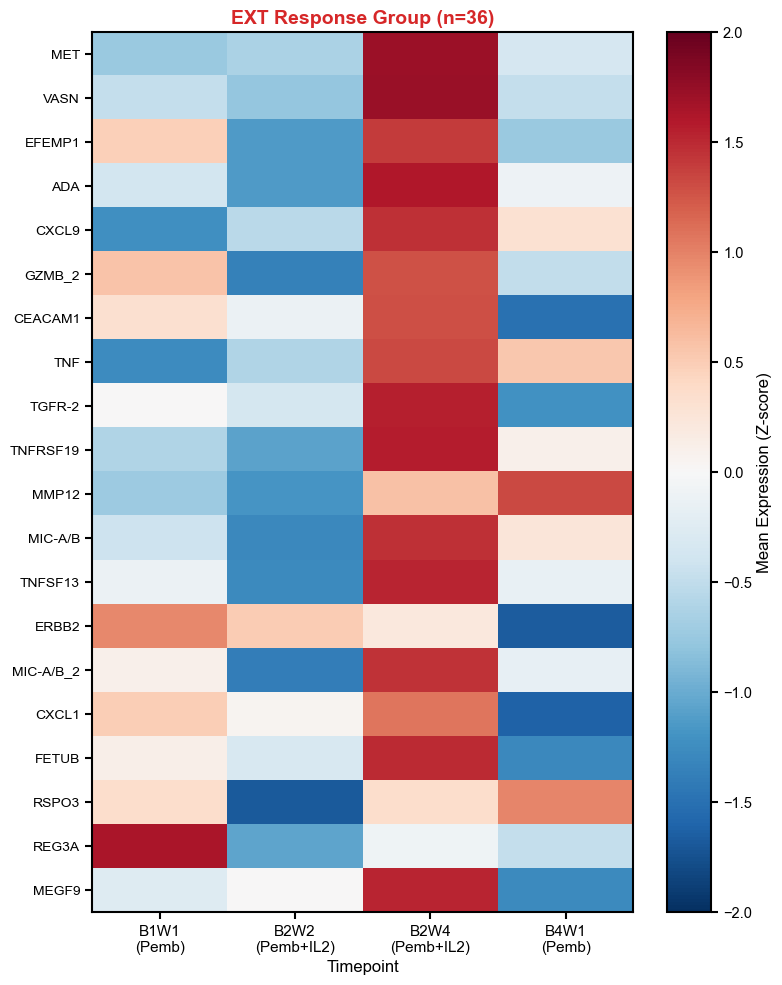

  Processing INT group...


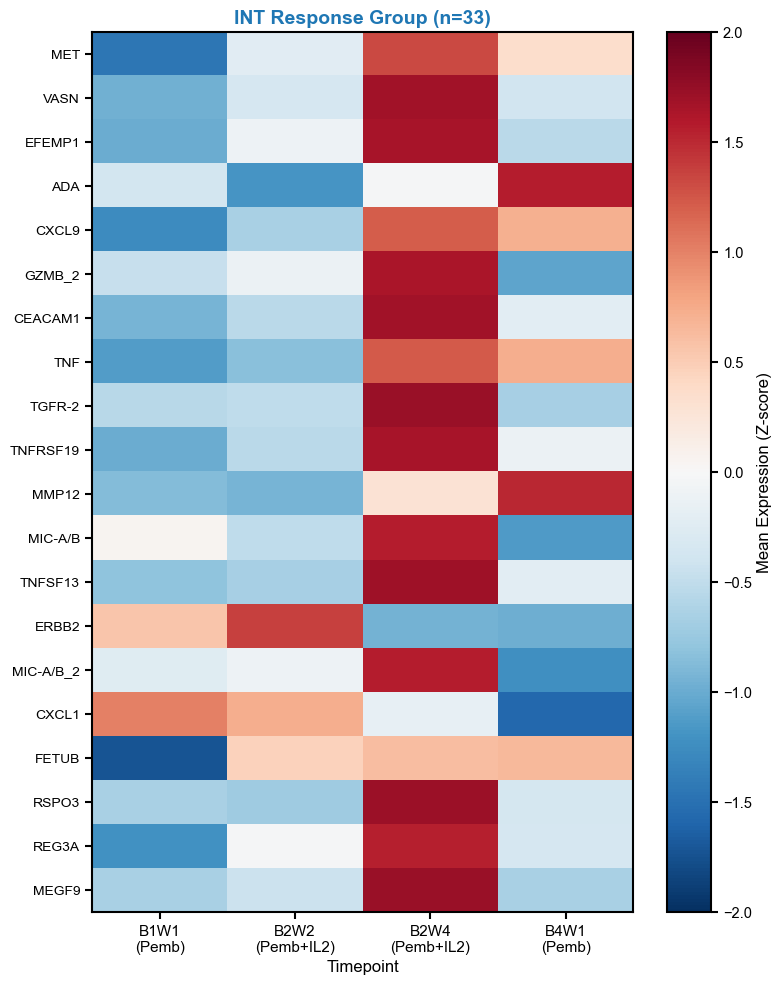

  Processing NON group...


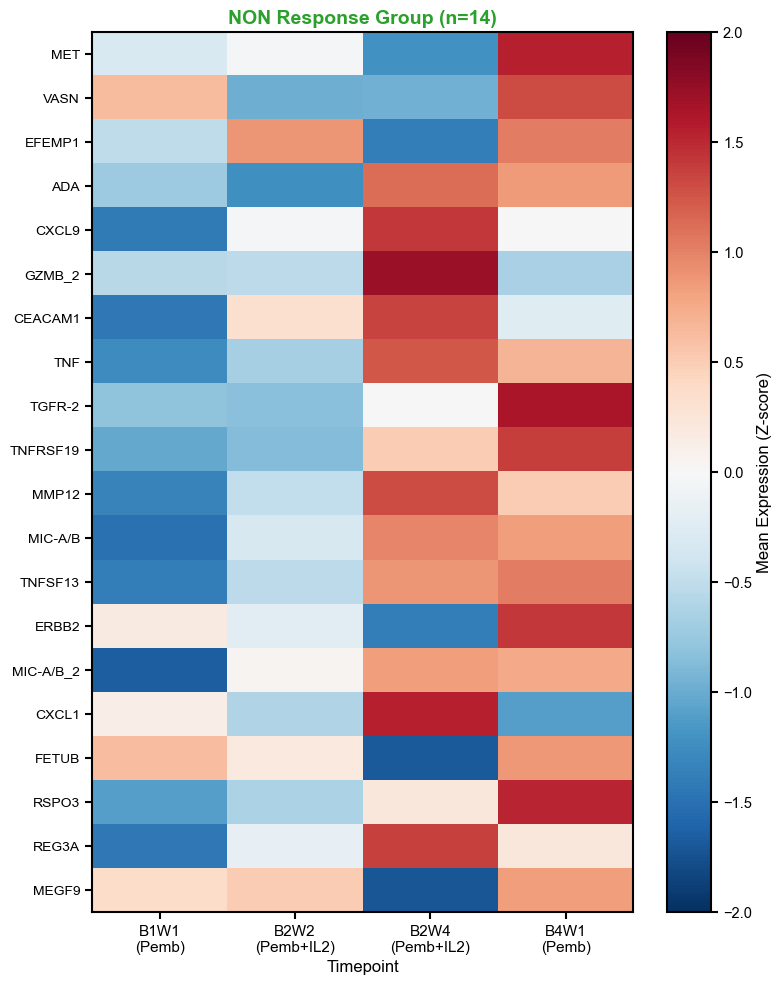

Individual Olink response heatmaps saved as PNG and PDF

Response group visualizations completed using 31 proteins!
These are the SAME proteins used in the main temporal analysis heatmap.

Response group analysis complete!
Note: The proteins shown in these heatmaps should now match those in the main temporal analysis.


In [13]:
def create_separate_response_heatmaps_olink(expression_data, sample_temporal_info, sample_to_response, significant_proteins, save_plots=True):
    """
    Create separate heatmaps for EXT, INT, and NON response groups - Olink version
    Uses the same protein selection as the main temporal analysis
    """
    print("Creating separate response group heatmaps for Olink...")
    
    # Use specific timepoints instead of blocks
    unique_timepoints = ['B1W1', 'B2W2', 'B2W4', 'B4W1']
    
    # Define response colors
    response_colors = {'EXT': '#d62728', 'INT': '#1f77b4', 'NON': '#2ca02c'}
    
    response_groups = ['EXT', 'INT', 'NON']
    
    for response in response_groups:
        print(f"  Processing {response} group...")
        
        # Calculate mean expression by timepoint for this response group
        expression_matrix = []
        protein_labels = []
        
        for protein in significant_proteins[:20]:  # Top 20 proteins - SAME AS MAIN ANALYSIS
            if protein in expression_data.index:
                means = []
                sample_counts = []
                
                for timepoint in unique_timepoints:
                    samples = [s for s in sample_to_response.keys() if 
                              sample_to_response[s] == response and 
                              sample_temporal_info.get(s) and
                              sample_temporal_info[s]['timepoint'] == timepoint]
                    
                    if samples:
                        # Get values and convert to numeric, handling non-numeric data
                        raw_values = expression_data.loc[protein, samples]
                        
                        # Convert to numeric, coercing errors to NaN
                        numeric_values = pd.to_numeric(raw_values, errors='coerce').values
                        
                        # Remove NaN values
                        valid_values = numeric_values[~np.isnan(numeric_values)]
                        
                        if len(valid_values) > 0:
                            means.append(np.mean(valid_values))
                            sample_counts.append(len(valid_values))
                        else:
                            means.append(np.nan)
                            sample_counts.append(0)
                    else:
                        means.append(np.nan)
                        sample_counts.append(0)
                
                # Only include proteins that have data for at least 2 timepoints
                valid_timepoints = sum(1 for m in means if not np.isnan(m))
                if valid_timepoints >= 2:
                    expression_matrix.append(means)
                    protein_labels.append(protein)
        
        if expression_matrix:
            expression_matrix = np.array(expression_matrix)
            
            # Z-score normalize each row (protein)
            expression_matrix_z = np.zeros_like(expression_matrix)
            for i in range(len(protein_labels)):
                row = expression_matrix[i, :]
                valid_mask = ~np.isnan(row)
                if np.sum(valid_mask) > 1:  # Need at least 2 valid values
                    row_mean = np.nanmean(row)
                    row_std = np.nanstd(row)
                    if row_std > 0:
                        expression_matrix_z[i, :] = (row - row_mean) / row_std
                    else:
                        expression_matrix_z[i, :] = row - row_mean
                else:
                    expression_matrix_z[i, :] = row  # Keep original if can't normalize
            
            # Create timepoint labels
            timepoint_labels = []
            for timepoint in unique_timepoints:
                if timepoint == 'B1W1':
                    timepoint_labels.append('B1W1\n(Pemb)')
                elif timepoint in ['B2W2', 'B2W4']:
                    timepoint_labels.append(f'{timepoint}\n(Pemb+IL2)')
                elif timepoint == 'B4W1':
                    timepoint_labels.append('B4W1\n(Pemb)')
                else:
                    timepoint_labels.append(timepoint)
            
            # Create heatmap with original styling
            plt.figure(figsize=(8, max(10, len(protein_labels) * 0.5)))
            
            # Handle NaN values by masking them
            masked_data = np.ma.masked_where(np.isnan(expression_matrix_z), expression_matrix_z)
            
            im = plt.imshow(masked_data, aspect='auto', cmap='RdBu_r', interpolation='none', vmin=-2, vmax=2)
            
            # Add colorbar
            cbar = plt.colorbar(im, shrink=1.0)
            cbar.set_label('Mean Expression (Z-score)', fontsize=12)
            
            # Add axis labels
            plt.yticks(np.arange(len(protein_labels)), protein_labels, fontsize=10)
            plt.xticks(np.arange(len(unique_timepoints)), timepoint_labels, fontsize=11)
            
            # Add title
            n_samples = sum(1 for s in sample_to_response.values() if s == response)
            plt.title(f'{response} Response Group (n={n_samples})', 
                     fontweight='bold', color=response_colors[response], fontsize=14)
            
            plt.xlabel('Timepoint', fontsize=12)
            
            plt.tight_layout()
            
            if save_plots:
                plt.savefig(f'olink_heatmap_{response}.png', dpi=300, bbox_inches='tight')
                plt.savefig(f'olink_heatmap_{response}.pdf', bbox_inches='tight')
            
            plt.show()
        else:
            print(f"    No valid data found for {response} group")
    
    if save_plots:
        print("Individual Olink response heatmaps saved as PNG and PDF")

def create_response_summary_table(expression_data, sample_temporal_info, sample_to_response):
    """
    Create a summary table showing sample counts by response group and timepoint
    """
    print("Creating response group summary table...")
    
    unique_timepoints = ['B1W1', 'B2W2', 'B2W4', 'B4W1']
    response_groups = ['EXT', 'INT', 'NON']
    
    # Create summary table
    summary_data = []
    
    for response in response_groups:
        for timepoint in unique_timepoints:
            samples = [s for s in sample_to_response.keys() if 
                      sample_to_response[s] == response and 
                      sample_temporal_info.get(s) and
                      sample_temporal_info[s]['timepoint'] == timepoint]
            
            summary_data.append({
                'Response_Group': response,
                'Timepoint': timepoint,
                'Sample_Count': len(samples)
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create pivot table for better display
    pivot_table = summary_df.pivot(index='Response_Group', columns='Timepoint', values='Sample_Count')
    pivot_table = pivot_table.fillna(0).astype(int)
    
    print("\nSample distribution by response group and timepoint:")
    print("="*60)
    print(pivot_table)
    
    # Save summary
    summary_df.to_csv('olink_response_summary.csv', index=False)
    pivot_table.to_csv('olink_response_pivot_summary.csv')
    
    print("\nSummary tables saved as CSV files")
    
    return summary_df, pivot_table

# EXECUTION CODE - Put this at the end of your main analysis script
print("\n" + "="*60)
print("CREATING SEPARATE RESPONSE GROUP VISUALIZATIONS")
print("="*60)

# First, create summary table to understand data distribution
try:
    summary_df, pivot_table = create_response_summary_table(filtered_data, sample_temporal_info, sample_to_response)
except Exception as e:
    print(f"Error creating summary table: {e}")

# USE THE SAME PROTEIN SELECTION METHOD AS THE MAIN ANALYSIS
print("\nUsing same protein selection method as main temporal analysis...")

try:
    # Check if we have temporal results from the main analysis
    if len(temporal_results_df) == 0:
        print("Warning: No temporal analysis results found. Using fallback protein selection...")
        # Fallback: use proteins with highest variance as before
        numeric_data = filtered_data.apply(lambda x: pd.to_numeric(x, errors='coerce'))
        protein_variances = numeric_data.var(axis=1, skipna=True).sort_values(ascending=False)
        min_samples_required = 5
        protein_sample_counts = numeric_data.count(axis=1)
        valid_proteins = protein_sample_counts[protein_sample_counts >= min_samples_required].index
        visualization_proteins = [p for p in protein_variances.index if p in valid_proteins][:20]
        print(f"  Using fallback method: selected {len(visualization_proteins)} proteins with highest variance")
        
    else:
        # SAME PROTEIN SELECTION AS MAIN ANALYSIS
        print("Using temporal analysis results for protein selection...")
        
        # Find proteins significant at multiple temporal levels
        protein_significance_counts = temporal_results_df[temporal_results_df['significant_raw']].groupby('Protein').size()
        multi_level_proteins = protein_significance_counts[protein_significance_counts > 1].index.tolist()

        # Find proteins with largest effect sizes across all analyses
        temporal_results_df['abs_cohens_d'] = temporal_results_df['cohens_d'].abs()
        max_effect_proteins = temporal_results_df.loc[
            temporal_results_df.groupby('Protein')['abs_cohens_d'].idxmax()
        ]
        top_effect_proteins = max_effect_proteins.nlargest(10, 'abs_cohens_d')['Protein'].tolist()

        # Combine for visualization (EXACTLY THE SAME AS MAIN ANALYSIS)
        visualization_proteins = list(set(multi_level_proteins + top_effect_proteins))
        
        print(f"  Proteins significant at multiple temporal levels: {len(multi_level_proteins)}")
        print(f"  Top effect size proteins: {len(top_effect_proteins)}")
        print(f"  Combined unique proteins for visualization: {len(visualization_proteins)}")
        
        if len(multi_level_proteins) > 0:
            print(f"  Multi-level significant proteins: {multi_level_proteins[:5]}")
        if len(top_effect_proteins) > 0:
            print(f"  Top effect size proteins: {top_effect_proteins[:5]}")
    
    if len(visualization_proteins) > 0:
        print(f"\nFinal protein list for visualization: {visualization_proteins[:10]}...")
        
        # Create separate heatmaps for each response group using THE SAME PROTEINS
        create_separate_response_heatmaps_olink(
            filtered_data, sample_temporal_info, sample_to_response, visualization_proteins
        )
        
        print(f"\nResponse group visualizations completed using {len(visualization_proteins)} proteins!")
        print("These are the SAME proteins used in the main temporal analysis heatmap.")
        
    else:
        print("No proteins available for visualization - check data availability.")

except Exception as e:
    print(f"Error in visualization: {e}")
    import traceback
    traceback.print_exc()

print("\nResponse group analysis complete!")
print("Note: The proteins shown in these heatmaps should now match those in the main temporal analysis.")